In [7]:
# Import the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar import vecm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import *


Functions used later in the code

In [8]:
def run_tests_c(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='c')
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Phillips Perron Test
    result = PhillipsPerron(data, trend='ct')
    test_statistic = round(result.stat, 2)
    pp_p_value = result.pvalue

    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if 1 - p_value > 0.01:
        asterisk_pp = '***'
    elif 1 - p_value < 0.05:
        asterisk_pp = '**'
    elif 1 - p_value < 0.1:
        asterisk_pp = '*'
    else:
        asterisk_pp = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    summary_df.loc['PhillipsPerron Test', variable.name] = str(test_statistic) + asterisk_pp
    
    return summary_df

def run_tests_ct(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='ct')
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Phillips Perron Test
    result = PhillipsPerron(data, trend='ct')
    test_statistic = round(result.stat, 2)
    pp_p_value = result.pvalue

    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if 1 - p_value < 0.01:
        asterisk_pp = '***'
    elif 1 - p_value < 0.05:
        asterisk_pp = '**'
    elif 1 - p_value < 0.1:
        asterisk_pp = '*'
    else:
        asterisk_pp = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    summary_df.loc['PhillipsPerron Test', variable.name] = str(test_statistic) + asterisk_pp
    
    return summary_df

def pp_nlag(variable, reg, lag_df):
    data = variable.dropna()
    result = PhillipsPerron(data, trend= reg)

    if variable.name not in lag_df.columns:
        lag_df[variable.name] = np.nan
    
        # Add test statistics to summary_df
        lag_df.loc['nlags', variable.name] = float(result.lags)

    return lag_df

def create_industry_dfs(treated_vars, industry_names, endog_vars, exog_vars):
  """
  Creates a dictionary of DataFrames, each containing time series for an industry
  (first column) and exogenous variables concatenated on the right. DataFrame names
  follow the format "industry_df".

  Args:
      treated_vars (pandas.DataFrame): DataFrame containing time series data.
      industry_names (list): List of industry names.
      endog_vars (list): List of endogenous variable names.
      exog_vars (list): List of exogenous variable names.

  Returns:
      dict: Dictionary of DataFrames, where keys are industry names and values
            are the corresponding DataFrames.
  """

  industry_dfs = {}
  for industry in industry_names:
    # Filter treated variables for the current industry
    industry_vars = [var for var in treated_vars.columns if var.startswith(industry)]
    industry_df = treated_vars[industry_vars].copy() # Select industry columns
    industry_df = pd.concat([industry_df, treated_vars[endog_vars]], axis=1)
    industry_df = industry_df.dropna()  # Drop rows with missing values
    
    exog_df = treated_vars[exog_vars].copy()
    common_index = industry_df.index.intersection(exog_df.index)
    industry_df = industry_df.loc[common_index]
    exog_df = exog_df.loc[common_index]


    if len(exog_df) != len(industry_df):
        exog_df = exog_df.iloc[-len(industry_df):]  # Truncate to match length of industry_df

    # Name the DataFrame
    industry_df.name = industry + "_df"

    industry_dfs[industry] = {"industry_df": industry_df, "exogenous_df": exog_df}

  return industry_dfs

In [9]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')

#make the date the index
data.set_index('Date', inplace=True)
data['PCEPI'] = data['PCEPI'] /100 # Male the inflation index with base 1 instead of 100
industries = data.iloc[:,6:].columns
industry_names = industries.tolist()
industry_names

nominal_vars = data[industry_names + ['GDP' , 'M1SL' , 'M2SL']]

real_vars = pd.DataFrame()

for var in nominal_vars.columns:
    real_vars[var] = nominal_vars[var] / data['PCEPI']

real_vars['PCEPI'] = data['PCEPI']

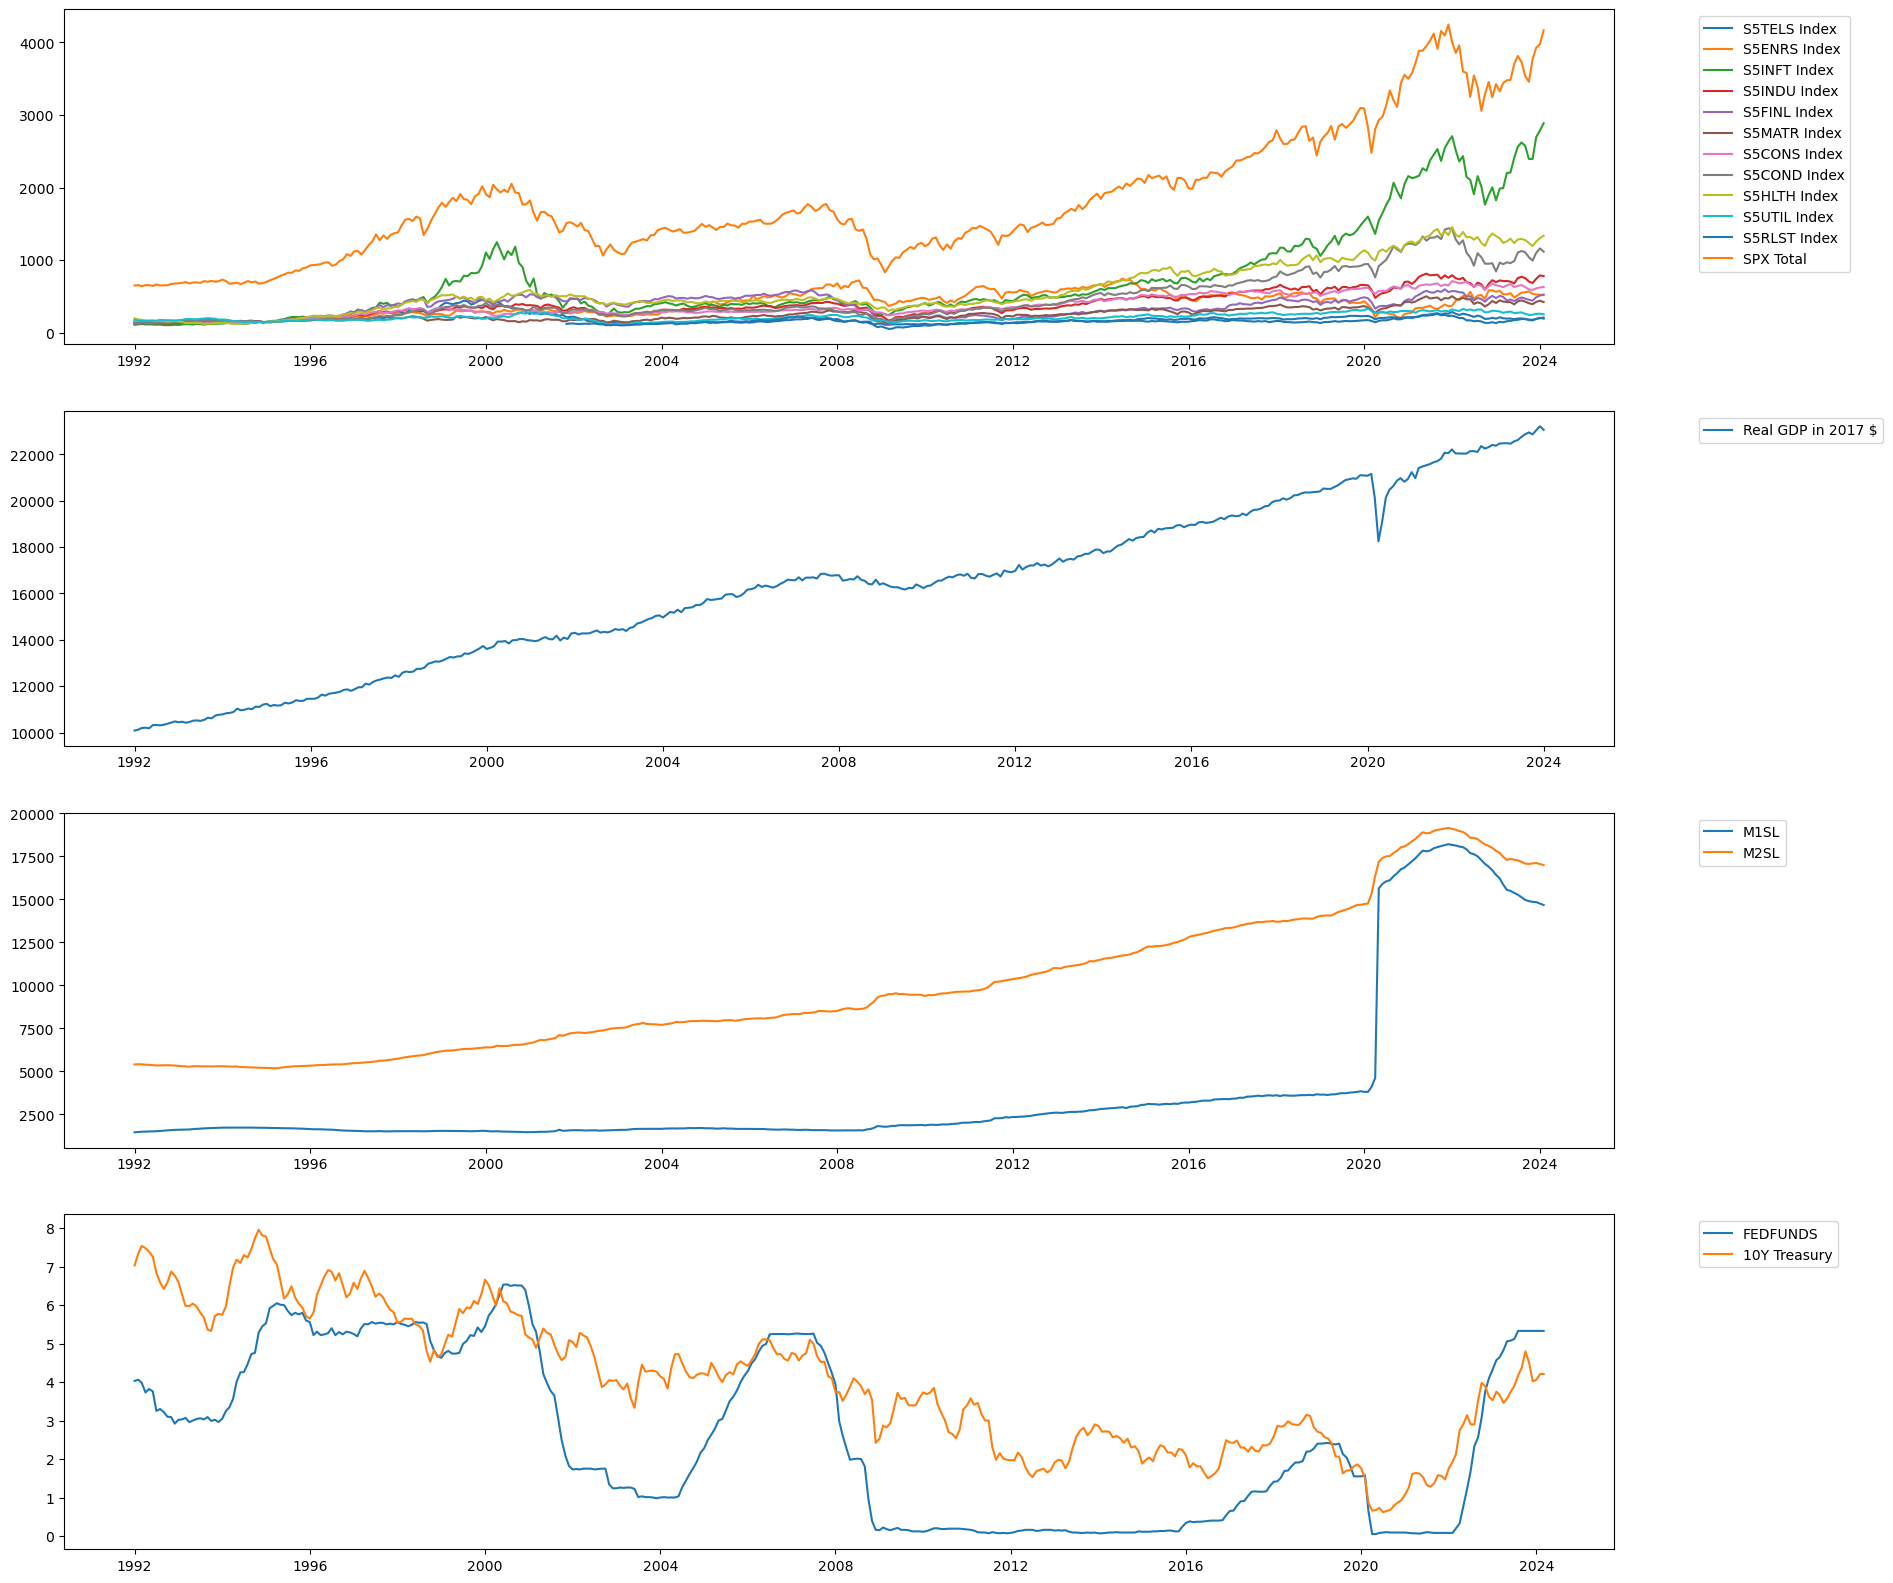

In [10]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(411)
ax.plot(real_vars.index, real_vars[industry_names])
ax.legend(real_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(real_vars.index, real_vars['GDP'])
ax.legend(['Real GDP in 2017 $'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(real_vars.index, real_vars[['M1SL', 'M2SL']])
ax.legend(['M1SL', 'M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

We perform A standard ADF and Phillips Perrin test for stationarity. The Phillips Perrin methodologyaccounts for Newey west standard errors (robust to serial correlation and heteroskedasticity). We find that S5MATR Index is stationary under the ADF test.

Information technologies and the total S&P 500 are stationary under the PP tests.


In [11]:
summary_df = pd.DataFrame(index=['ADF Test', 'PhillipsPerron Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(real_vars[industry], summary_df)

run_tests_ct(real_vars['GDP'], summary_df)
run_tests_ct(real_vars['M1SL'], summary_df)
run_tests_ct(real_vars['M2SL'], summary_df)
run_tests_c(data['FEDFUNDS'], summary_df)
run_tests_c(data['10Y Treasury'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_30177/3603778619.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.88' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_30177/3603778619.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_30177/3603778619.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.13' has dt

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total,GDP,M1SL,M2SL,FEDFUNDS,10Y Treasury
ADF Test,-2.88,-2.1,-0.13,-2.48,-2.19,-3.53**,-1.81,-1.79,-1.28,-3.23*,-2.71,-0.91,-1.82,-1.41,-2.95,-2.74*,-2.21
PhillipsPerron Test,-2.45,-2.4,-0.05***,-2.36,-2.09,-3.56,-2.41,-1.85,-1.38,-2.97,-2.84,-1.2**,-2.79,-1.63,-2.23,-1.68***,-1.98***


Given the previous results, we implement Newey West standard errors to account for the heteroskedasticty of the error terms. All variables become non-stationary.

Given the shape of the graphs, it seems that there may be a compounding effect going on with the industry indeces. We thus convert them to logs and perform the standard ADF test. With this specification, S5MATR Index, S5UTIL Index and M2 are all stationary.

In [13]:
real_vars = real_vars.drop('PCEPI', axis=1)
log_vars = np.log(real_vars)
treated_vars = log_vars.copy()
treated_vars[['10Y Treasury', 'FEDFUNDS']] = data[['10Y Treasury', 'FEDFUNDS']]


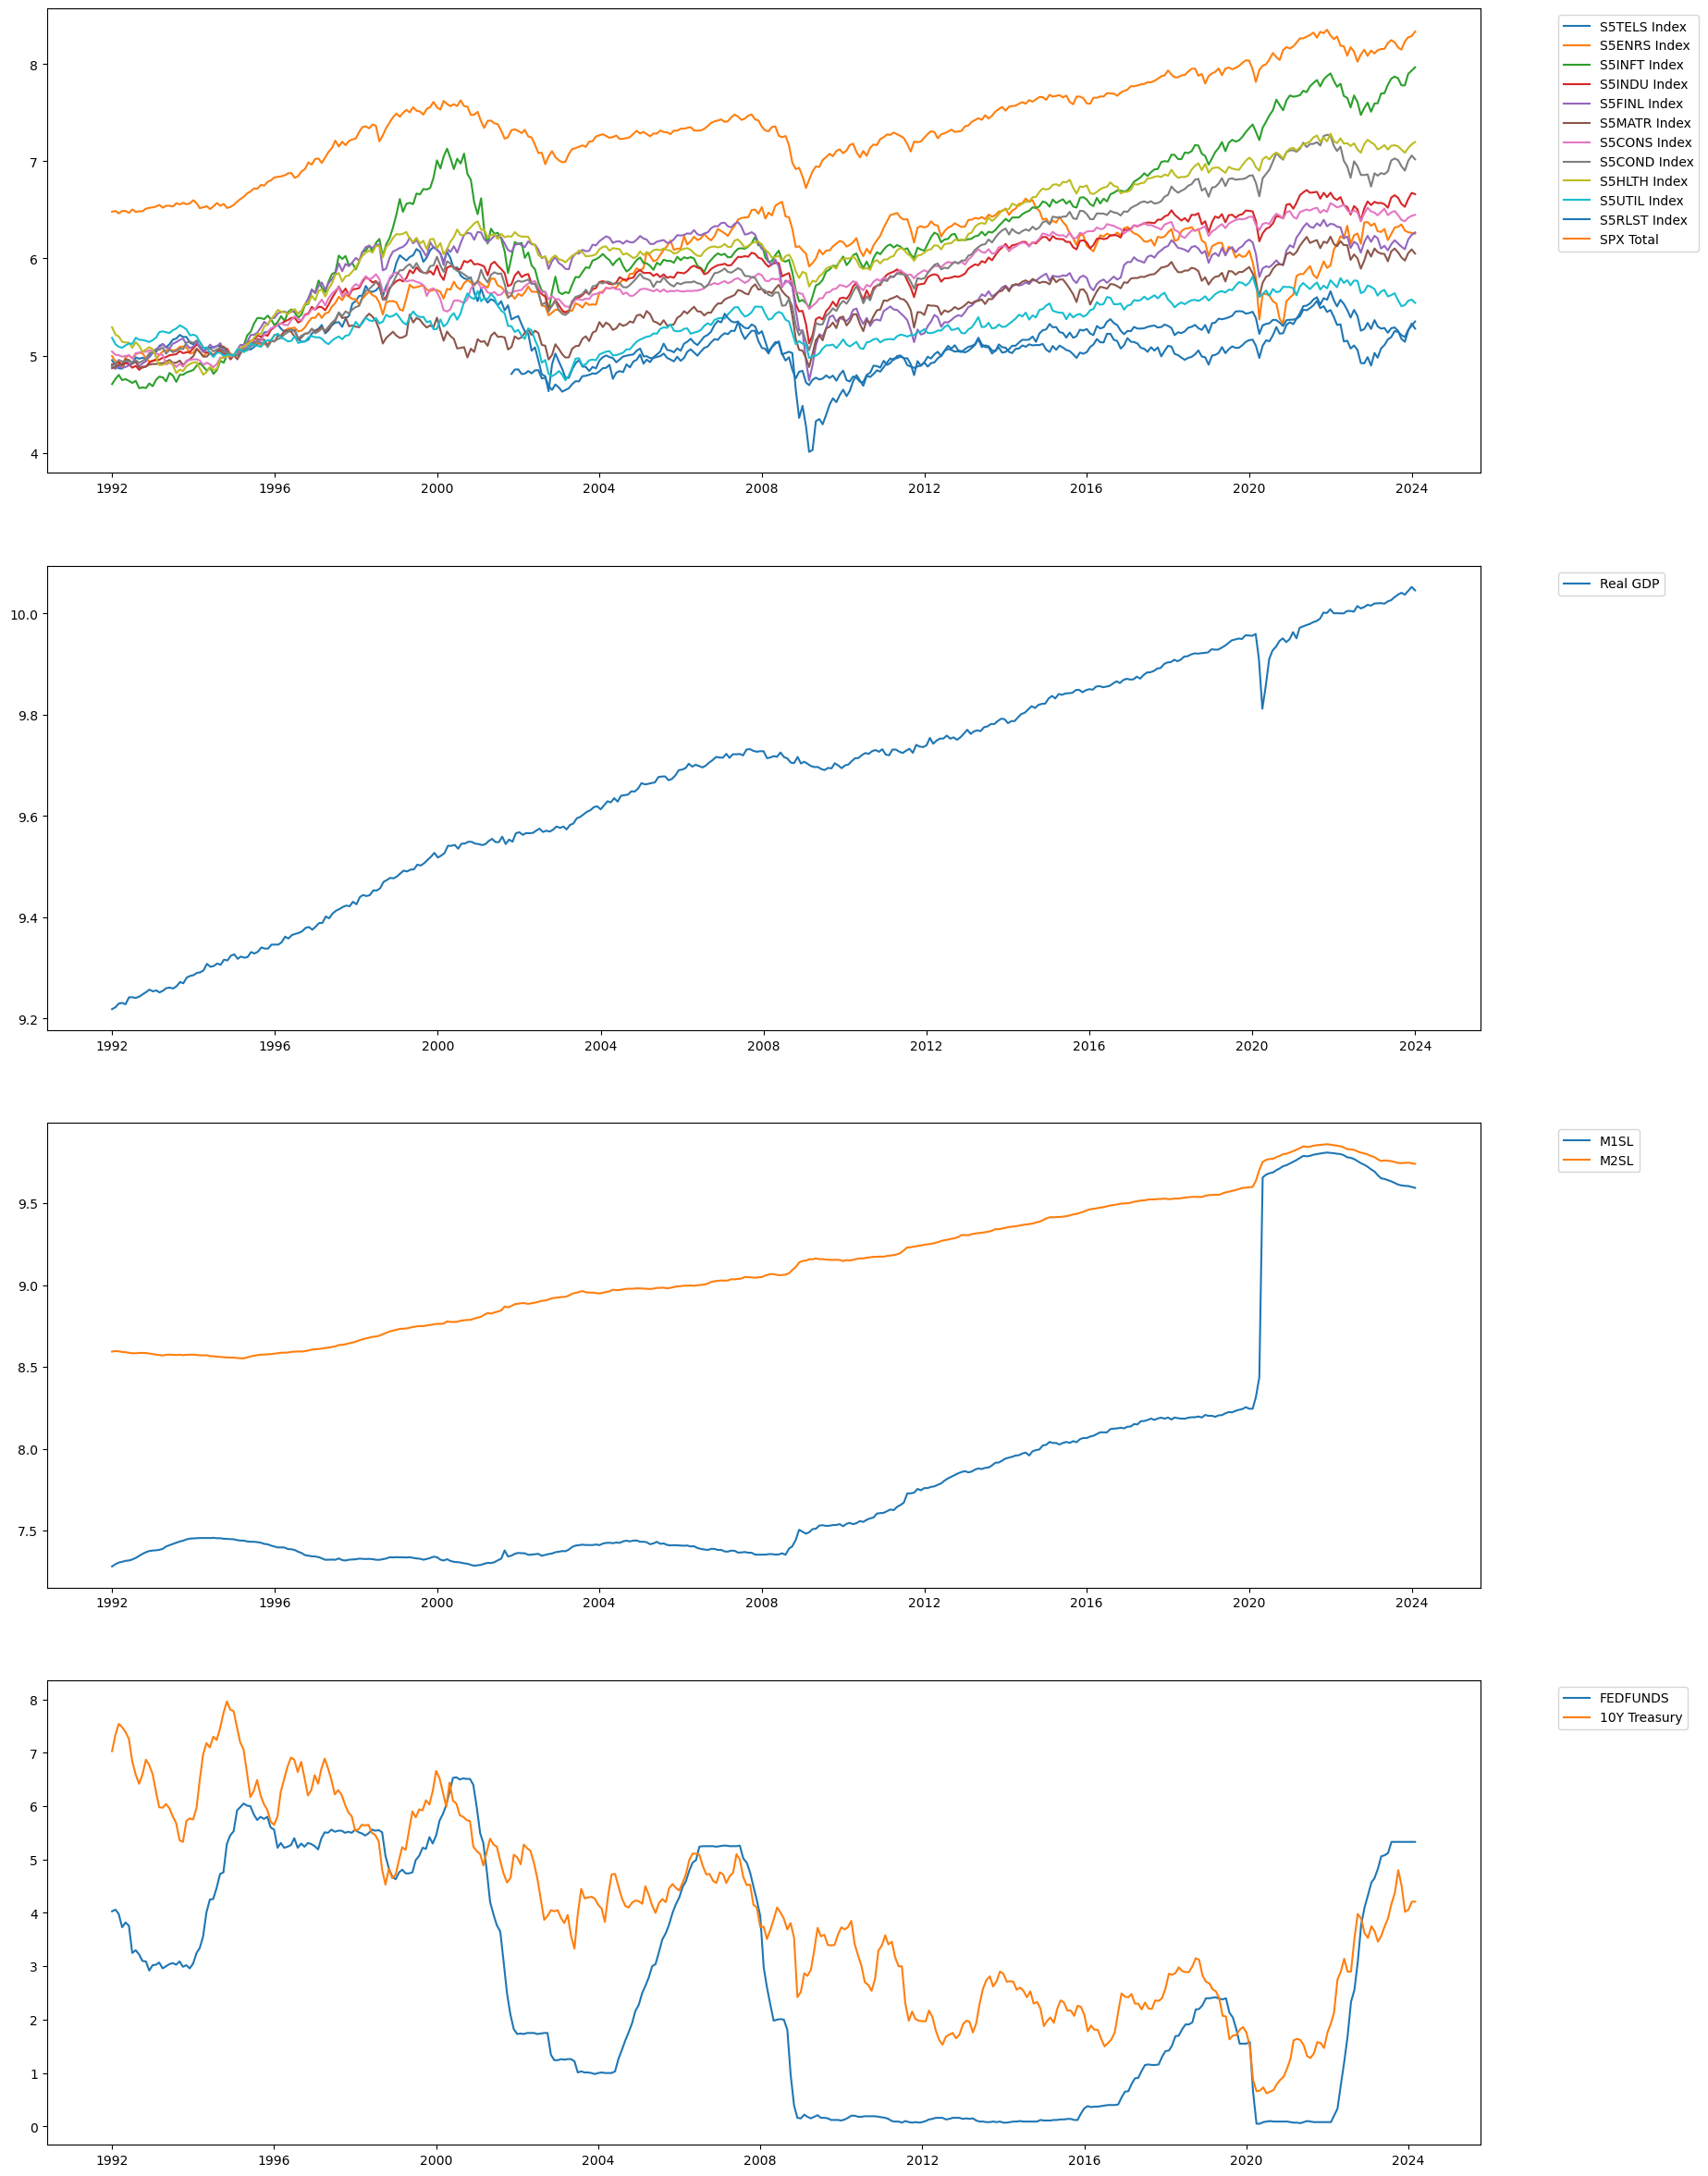

In [14]:
plt.figure(figsize=(20, 30))
ax = plt.subplot(411)
ax.plot(treated_vars.index, treated_vars[industry_names])
ax.legend(treated_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(treated_vars.index, treated_vars[['GDP']])
ax.legend(['Real GDP'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(treated_vars.index, treated_vars[['M1SL', 'M2SL']])
ax.legend(['M1SL', 'M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [15]:
summary_df = pd.DataFrame(index=['ADF Test', 'PhillipsPerron Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(treated_vars[industry], summary_df)

run_tests_ct(treated_vars['GDP'], summary_df)
run_tests_ct(treated_vars['M1SL'], summary_df)
run_tests_ct(treated_vars['M2SL'], summary_df)
run_tests_c(data['FEDFUNDS'], summary_df)
run_tests_c(data['10Y Treasury'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_30177/3603778619.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.05' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_30177/3603778619.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.11' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_30177/3603778619.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.46' has d

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total,GDP,M1SL,M2SL,FEDFUNDS,10Y Treasury
ADF Test,-3.05,-2.11,-1.46,-2.49,-2.13,-3.94**,-2.16,-1.98,-2.12,-3.43**,-2.78,-1.71,-2.2,-1.29,-3.82**,-2.74*,-2.21
PhillipsPerron Test,-2.45,-2.15,-1.78,-2.62,-2.17,-4.02,-2.37,-2.14,-1.88,-2.98,-2.84,-1.98,-2.37,-1.37,-3.19,-1.68***,-1.98***


##Var model for exog variables

In [16]:
#By definition, lag length for each variable is '12 * (nobs/100) ** (1/4)'

lag_df = pd.DataFrame(index=['nlags'])

pp_nlag(data['FEDFUNDS'], 'c', lag_df)
pp_nlag(data['10Y Treasury'], 'c', lag_df)

,FEDFUNDS,10Y Treasury
nlags,17.0,17.0


In [17]:
X = data[['FEDFUNDS', '10Y Treasury']].dropna().copy()
# Fit VAR model
model = VAR(X)
print(model.select_order(maxlags=20, trend='c').summary())


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.526       1.547       4.599       1.534
1       -6.480      -6.416    0.001533      -6.455
2       -7.110     -7.004*   0.0008167      -7.068
3       -7.141      -6.992   0.0007923      -7.081
4       -7.170      -6.978   0.0007696     -7.094*
5       -7.156      -6.922   0.0007805      -7.063
6       -7.167      -6.890   0.0007718      -7.057
7      -7.174*      -6.855  0.0007661*      -7.047
8       -7.172      -6.811   0.0007676      -7.029
9       -7.171      -6.766   0.0007690      -7.010
10      -7.158      -6.711   0.0007785      -6.981
11      -7.143      -6.653   0.0007909      -6.948
12      -7.129      -6.597   0.0008016      -6.918
13      -7.121      -6.546   0.0008086      -6.892
14      -7.107      -6.490   0.0008197      -6.862
15      -7.108      -6.448   0.0008191      -6.846
16      -7.102      -6.399   0.

We follow the AIC suggestion of 7 lags on interest rates for the VAR model

In [18]:
order = 7  # Order of VAR model
results = model.fit(order)

# Print summary of the model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Apr, 2024
Time:                     16:47:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.88853
Nobs:                     380.000    HQIC:                  -7.07616
Log likelihood:           319.530    FPE:                0.000746949
AIC:                     -7.19960    Det(Omega_mle):     0.000691296
--------------------------------------------------------------------
Results for equation FEDFUNDS
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.029132         0.018118           -1.608           0.108
L1.FEDFUNDS             1.357286         0.051112           26.555           0.000
L1.10Y Treasury         0.157586         0.031272

In [19]:
roots = results.roots

all_stable = all(np.abs(root) > 1 for root in roots)
if all_stable:
    print("The VAR model is stable.")
else:
    print("The VAR model is not stable.")

The VAR model is stable.


In [20]:
# Forecast using the VAR model
last_lags = data[['FEDFUNDS', '10Y Treasury']].tail(int(max(lag_df.values.flatten())))


In [21]:
forecast_steps = 12  # 3 years forecast
forecast = results.forecast(y=last_lags.values, steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps, freq='M')

# Create a DataFrame for the forecasted values
exogforecast = pd.DataFrame(forecast, columns=['FEDFUNDS', '10Y Treasury'], index = forecast_index)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_30177/4145924541.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps, freq='M')


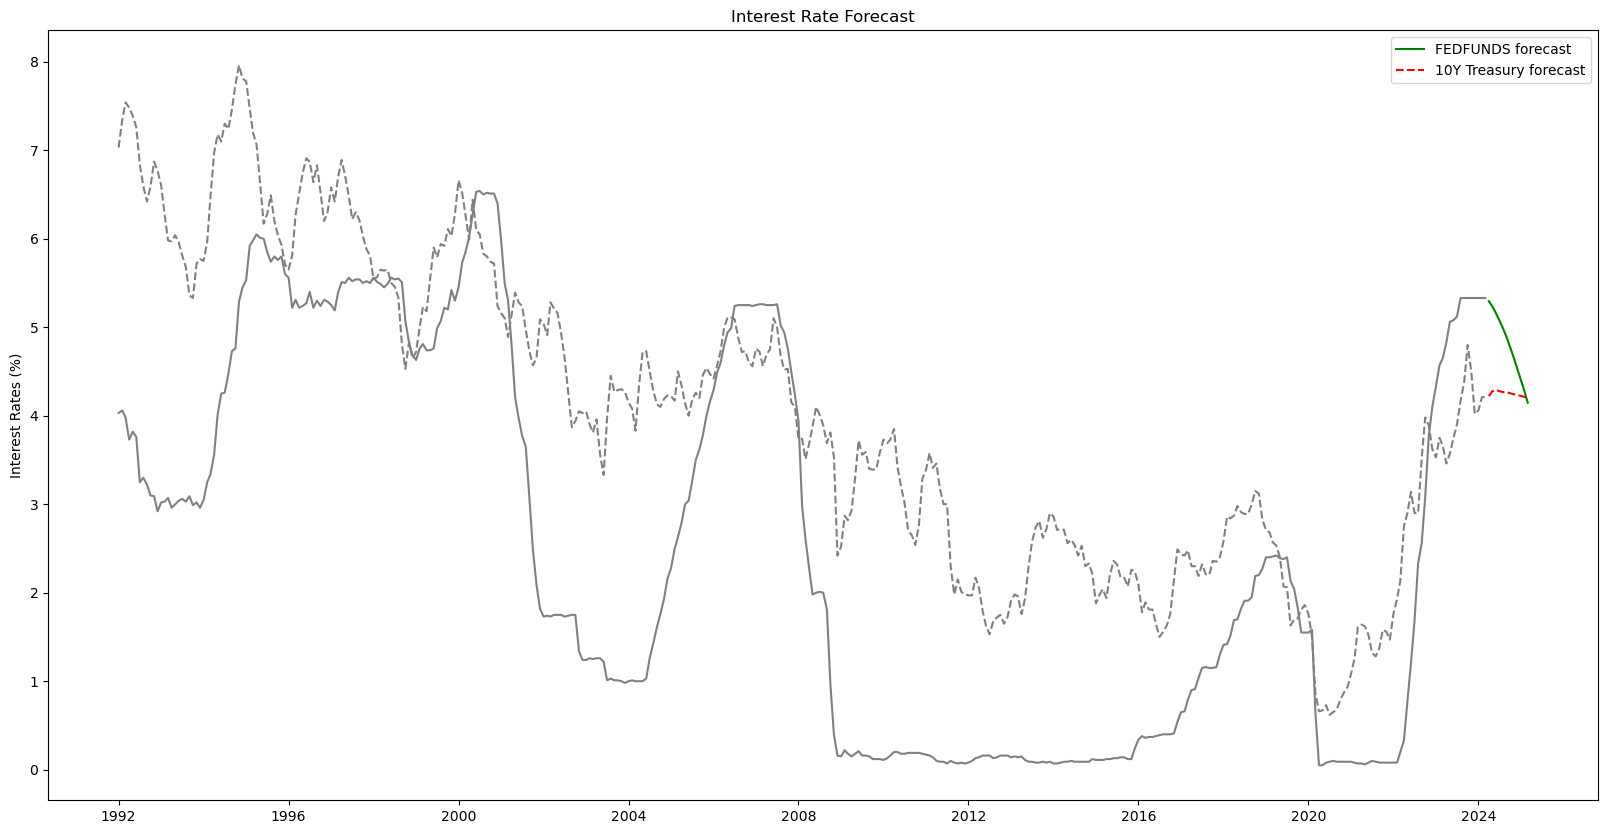

In [22]:
#Plotting interest rate forecasts
plt.figure(figsize=(20, 10))
plt.plot(exogforecast['FEDFUNDS'], color='green', label='FEDFUNDS forecast')
plt.plot(exogforecast['10Y Treasury'], color='red', linestyle='dashed', label='10Y Treasury forecast')
plt.plot(data['FEDFUNDS'], color='gray', label='FEDFUNDS')
plt.plot(data['10Y Treasury'], color='gray', linestyle='dashed', label='10Y Treasury')
plt.title('Interest Rate Forecast')
plt.ylabel('Interest Rates (%)')
plt.legend(['FEDFUNDS forecast', '10Y Treasury forecast'])


We will now use this model to forecast the interest rates for the VECM.

In [23]:
from statsmodels.tsa.vector_ar.vecm import VECM
# Assuming you have the forecast values for the exogenous variables stored in the 'forecast_df' DataFrame

# Import the VECM class
# Specify the endogenous variables
endog_vars = [var for var in treated_vars if var not in industry_names and var not in ['10Y Treasury', 'FEDFUNDS']]

# Specify the exogenous variables
exog_vars = ['10Y Treasury', 'FEDFUNDS']

industry_dataframes = create_industry_dfs(treated_vars, industry_names, endog_vars, exog_vars)

In [24]:
# Specify the maximum number of lags to consider
maxlags = 12

# Specify the deterministic term (e.g., "ci" for constant and trend)
deterministic = "ci"

lag_order_df = pd.DataFrame(index=[['AIC', 'BIC', 'FPE', 'HQIC']])

for industry_name in industry_dataframes.keys():
    print(industry_name)
    industry_df = industry_dataframes[industry_name]['industry_df']
    exogenous_df = industry_dataframes[industry_name]['exogenous_df']
    
    # Select the VECM model order
    model_order = select_order(industry_df, maxlags=maxlags, deterministic=deterministic, exog = exogenous_df)
    aic = model_order.aic
    bic = model_order.bic
    fpe = model_order.fpe
    hqic = model_order.hqic
    lag_order_df[industry_name] = [aic, bic, fpe, hqic]

lag_order_df

S5TELS Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5ENRS Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5INFT Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5INDU Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5FINL Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5MATR Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5CONS Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5COND Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5HLTH Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5UTIL Index


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5RLST Index
SPX Total


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total
AIC,4,4,4,4,6,4,4,4,4,4,4,4
BIC,2,2,2,2,2,2,2,2,2,2,1,2
FPE,4,4,4,4,6,4,4,4,4,4,4,4
HQIC,2,2,3,2,2,2,2,2,2,3,2,2


In [25]:
coint_rank_df = pd.DataFrame(index=[['number of coint vectors']])

for industry_name in industry_dataframes.keys():
    industry_df = industry_dataframes[industry_name]['industry_df']
    exogenous_df = industry_dataframes[industry_name]['exogenous_df']
    
    # Select the VECM model order
    rank = vecm.select_coint_rank(industry_df, det_order=0, k_ar_diff=lag_order_df[industry_name].iloc[0], method='trace', signif=0.05)
    coint_rank_df[industry_name] = rank.rank

coint_rank_df

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total
number of coint vectors,0,0,0,1,0,1,1,1,0,0,0,0


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

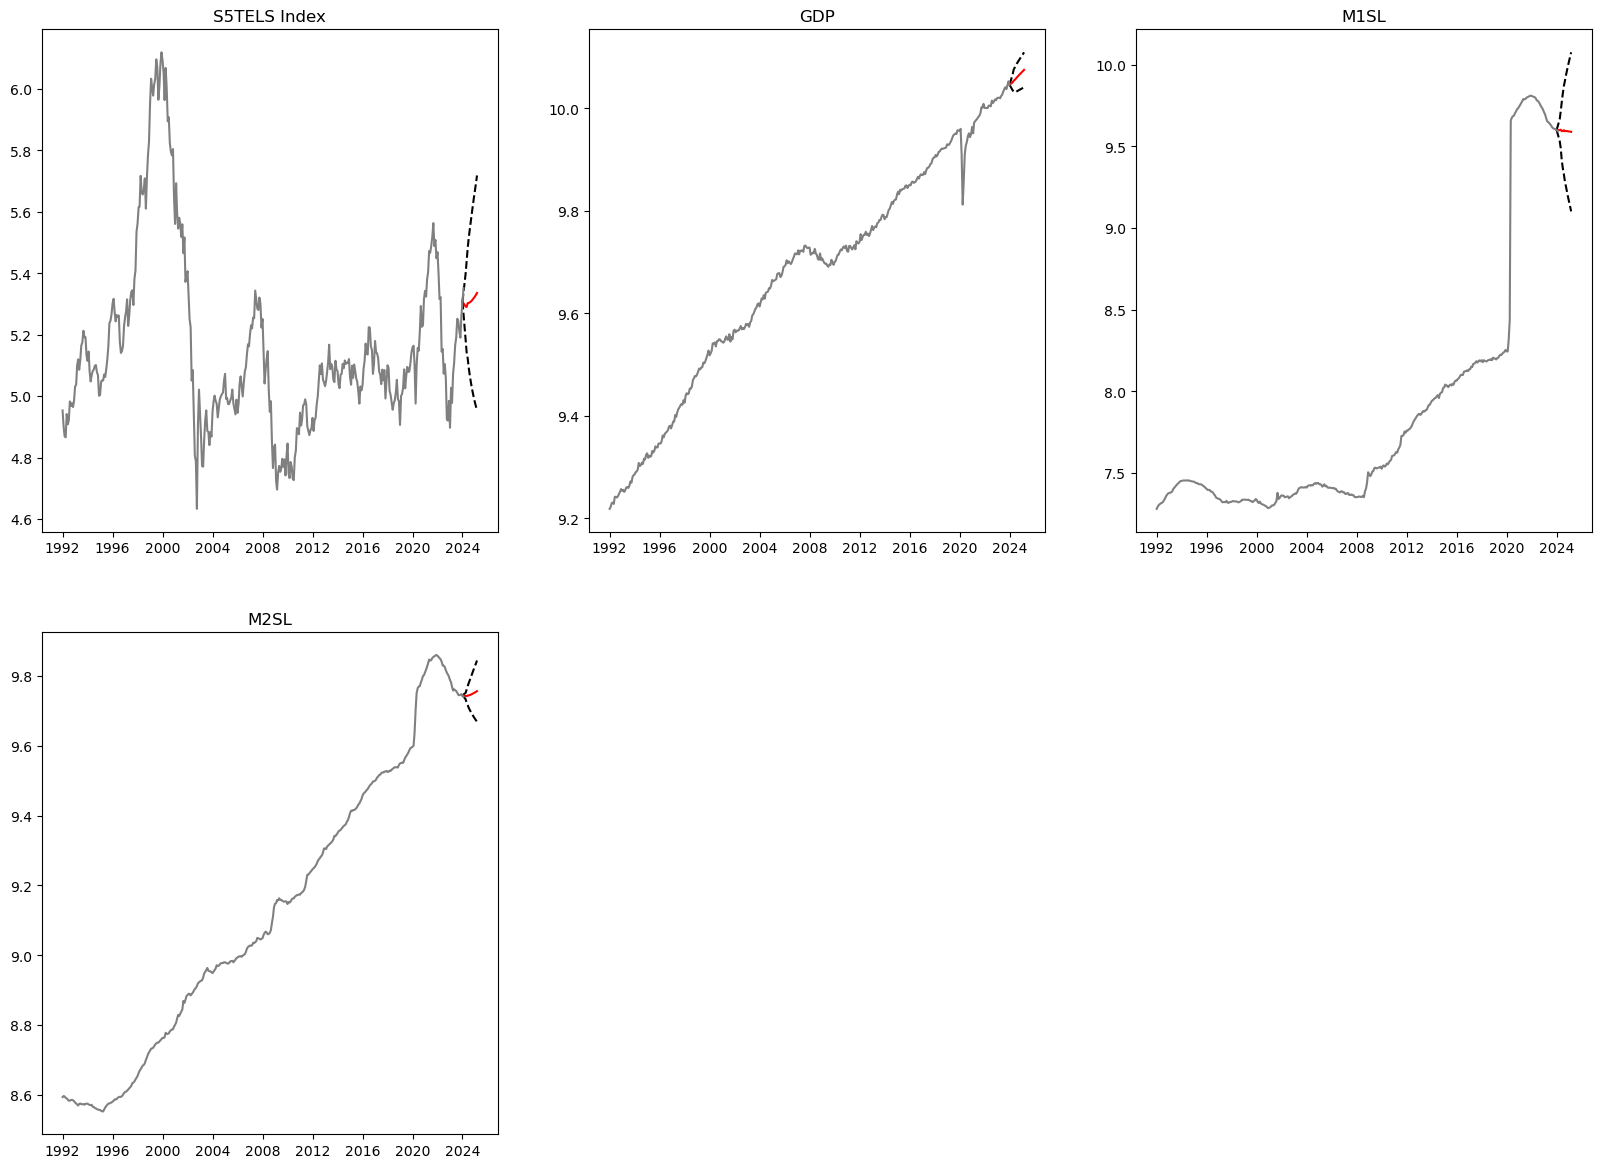

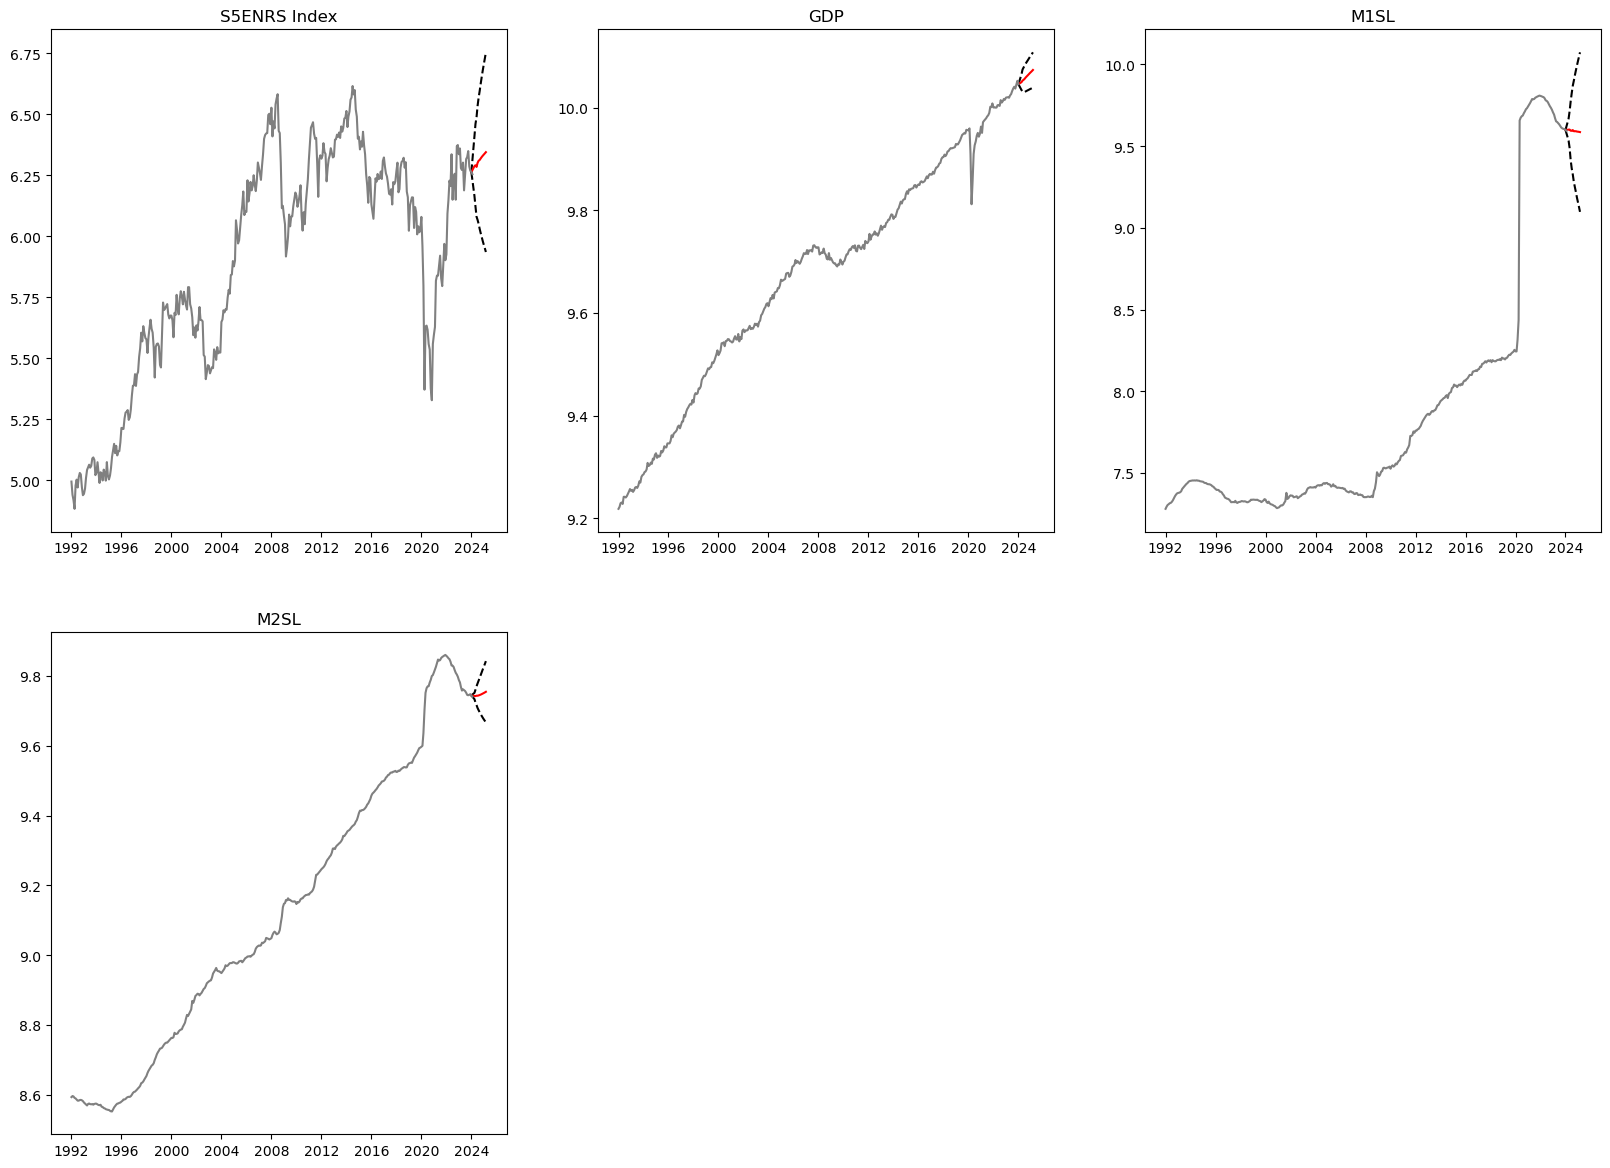

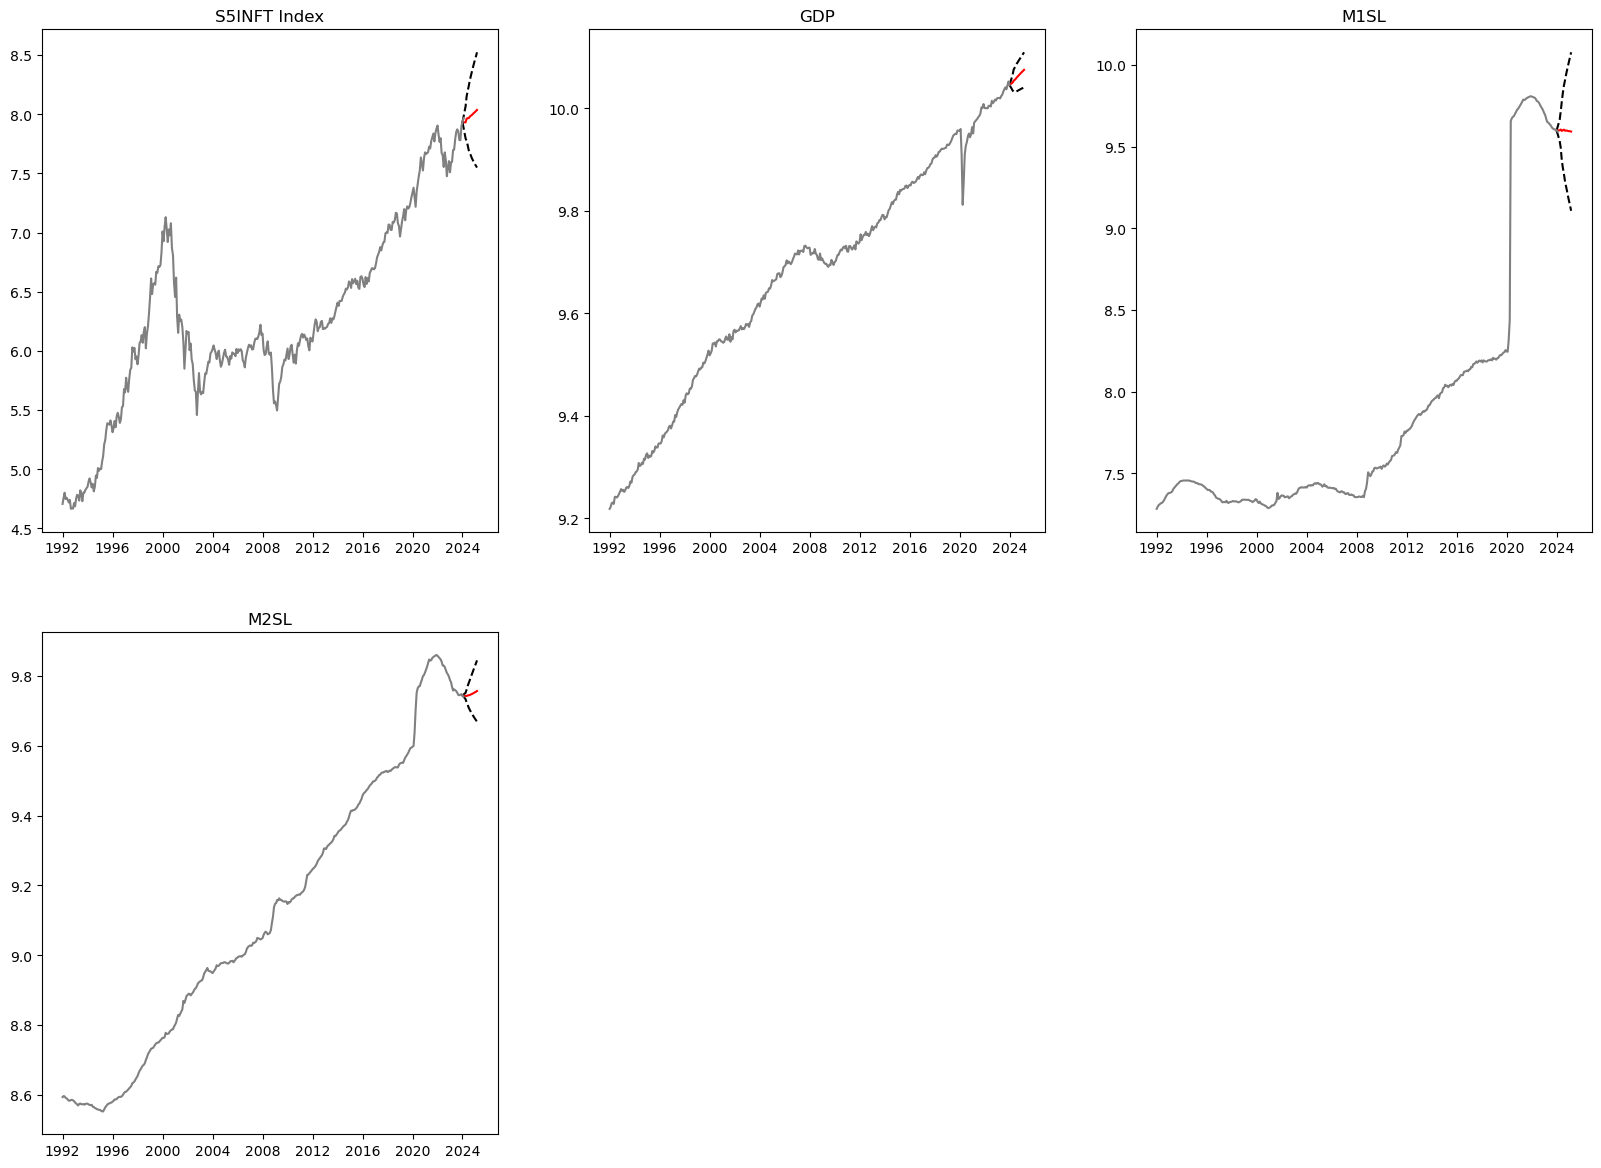

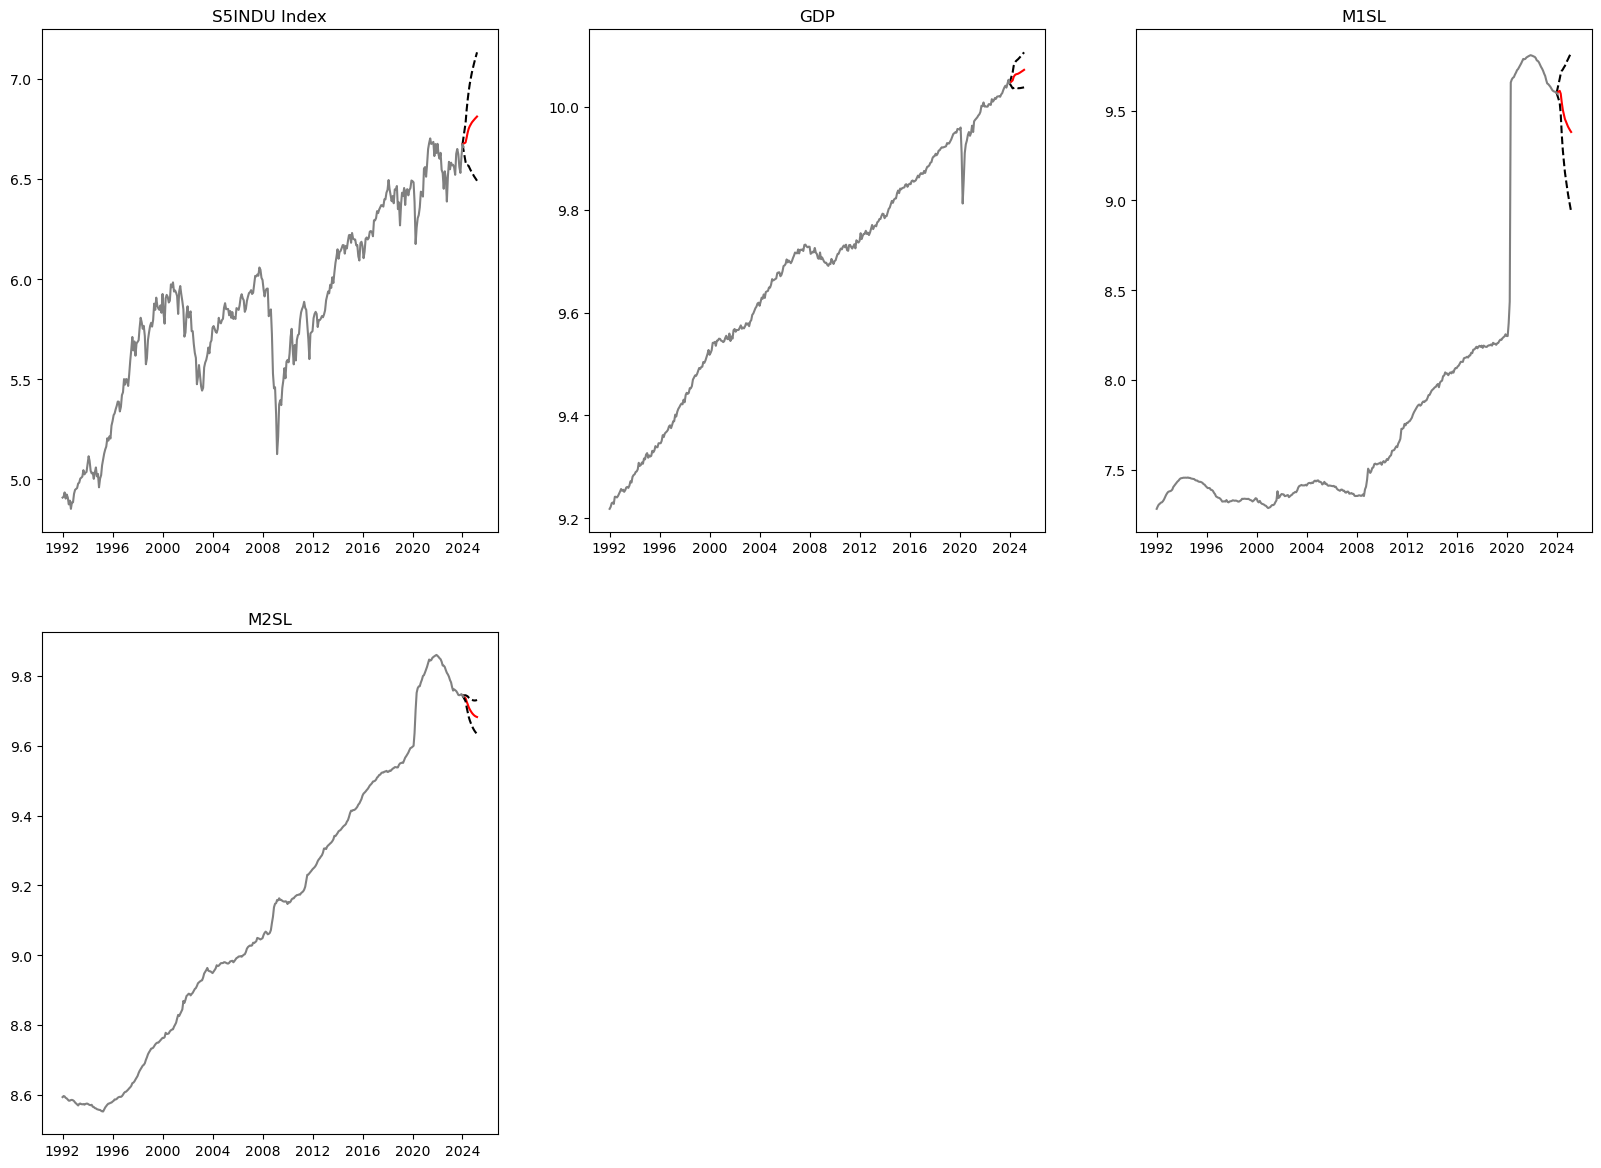

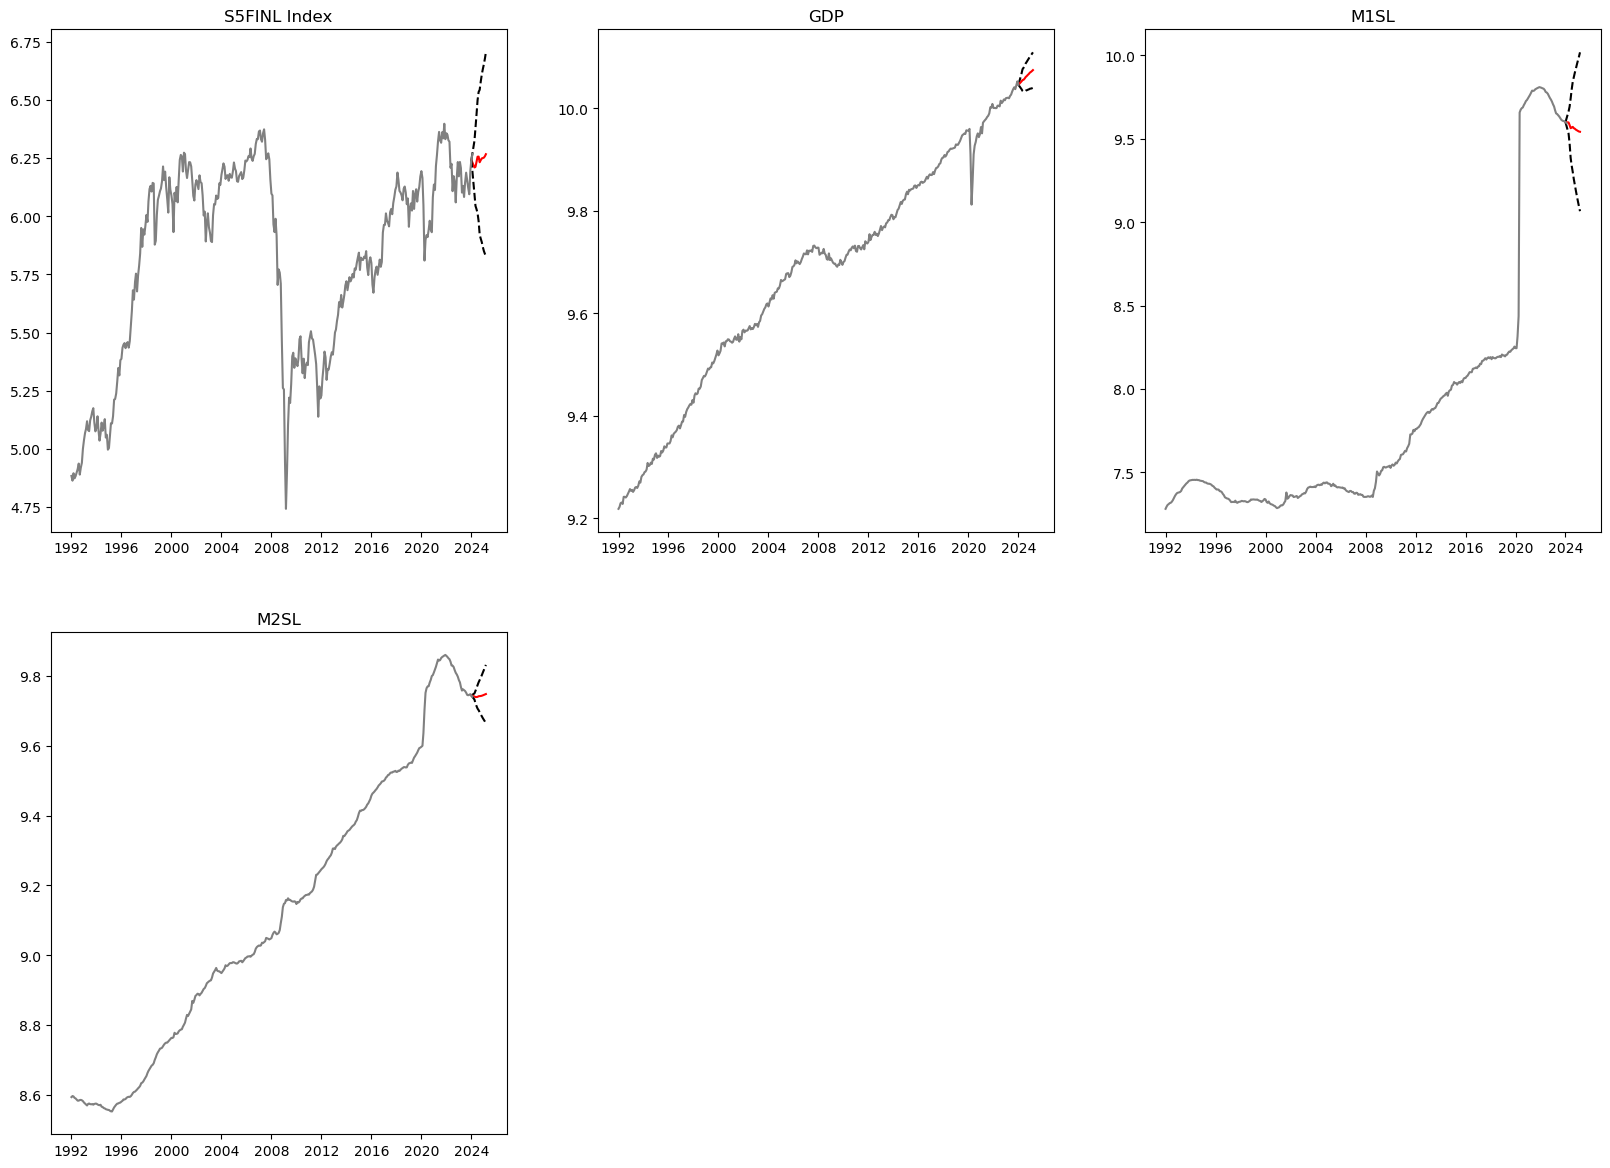

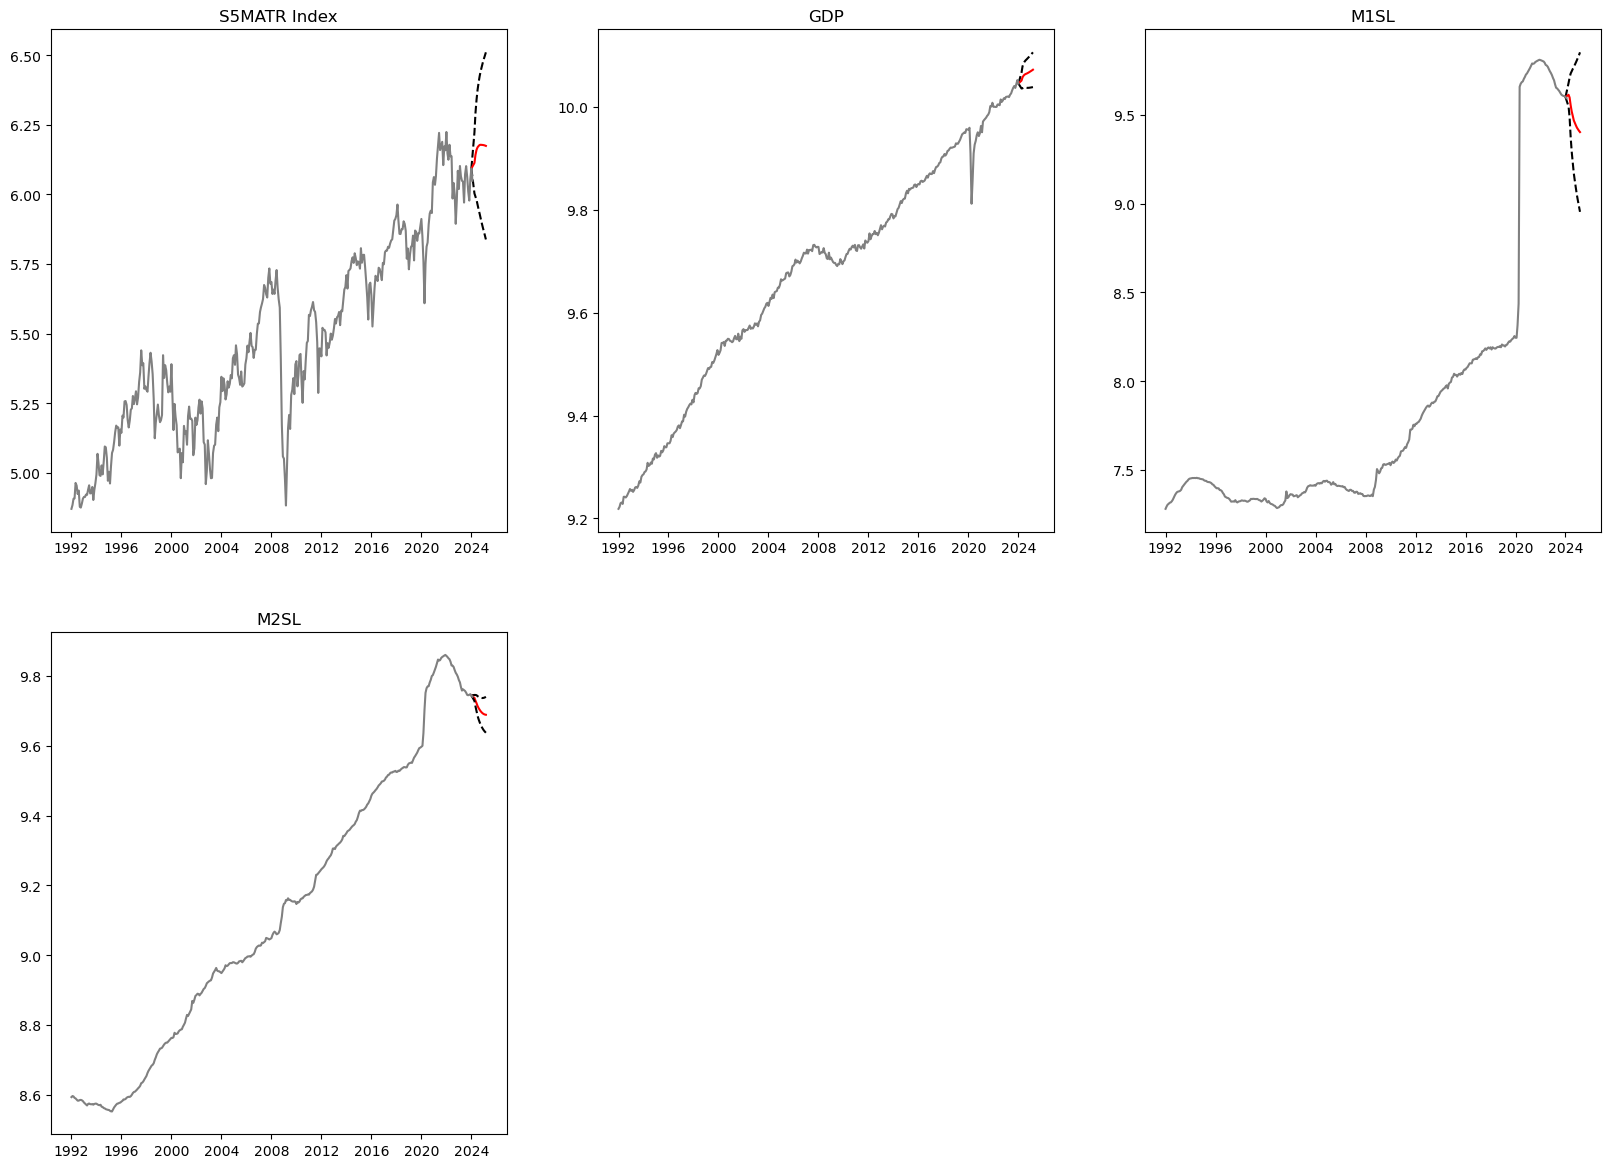

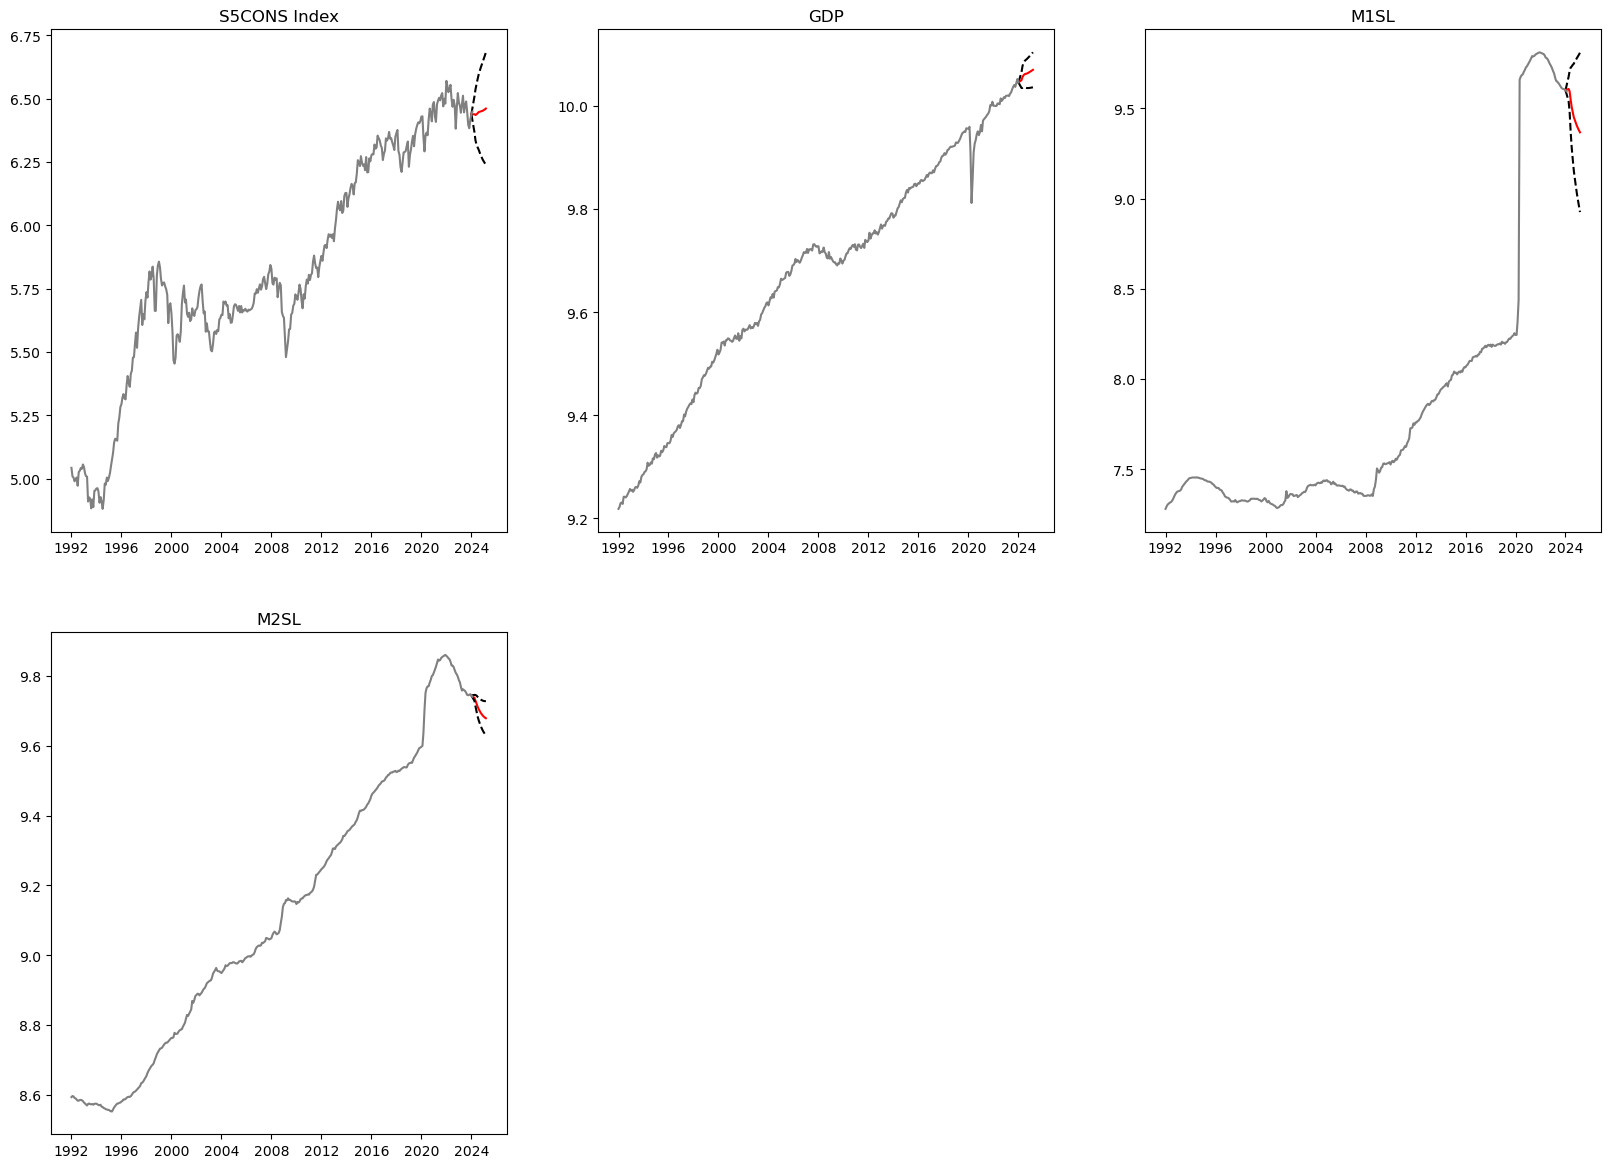

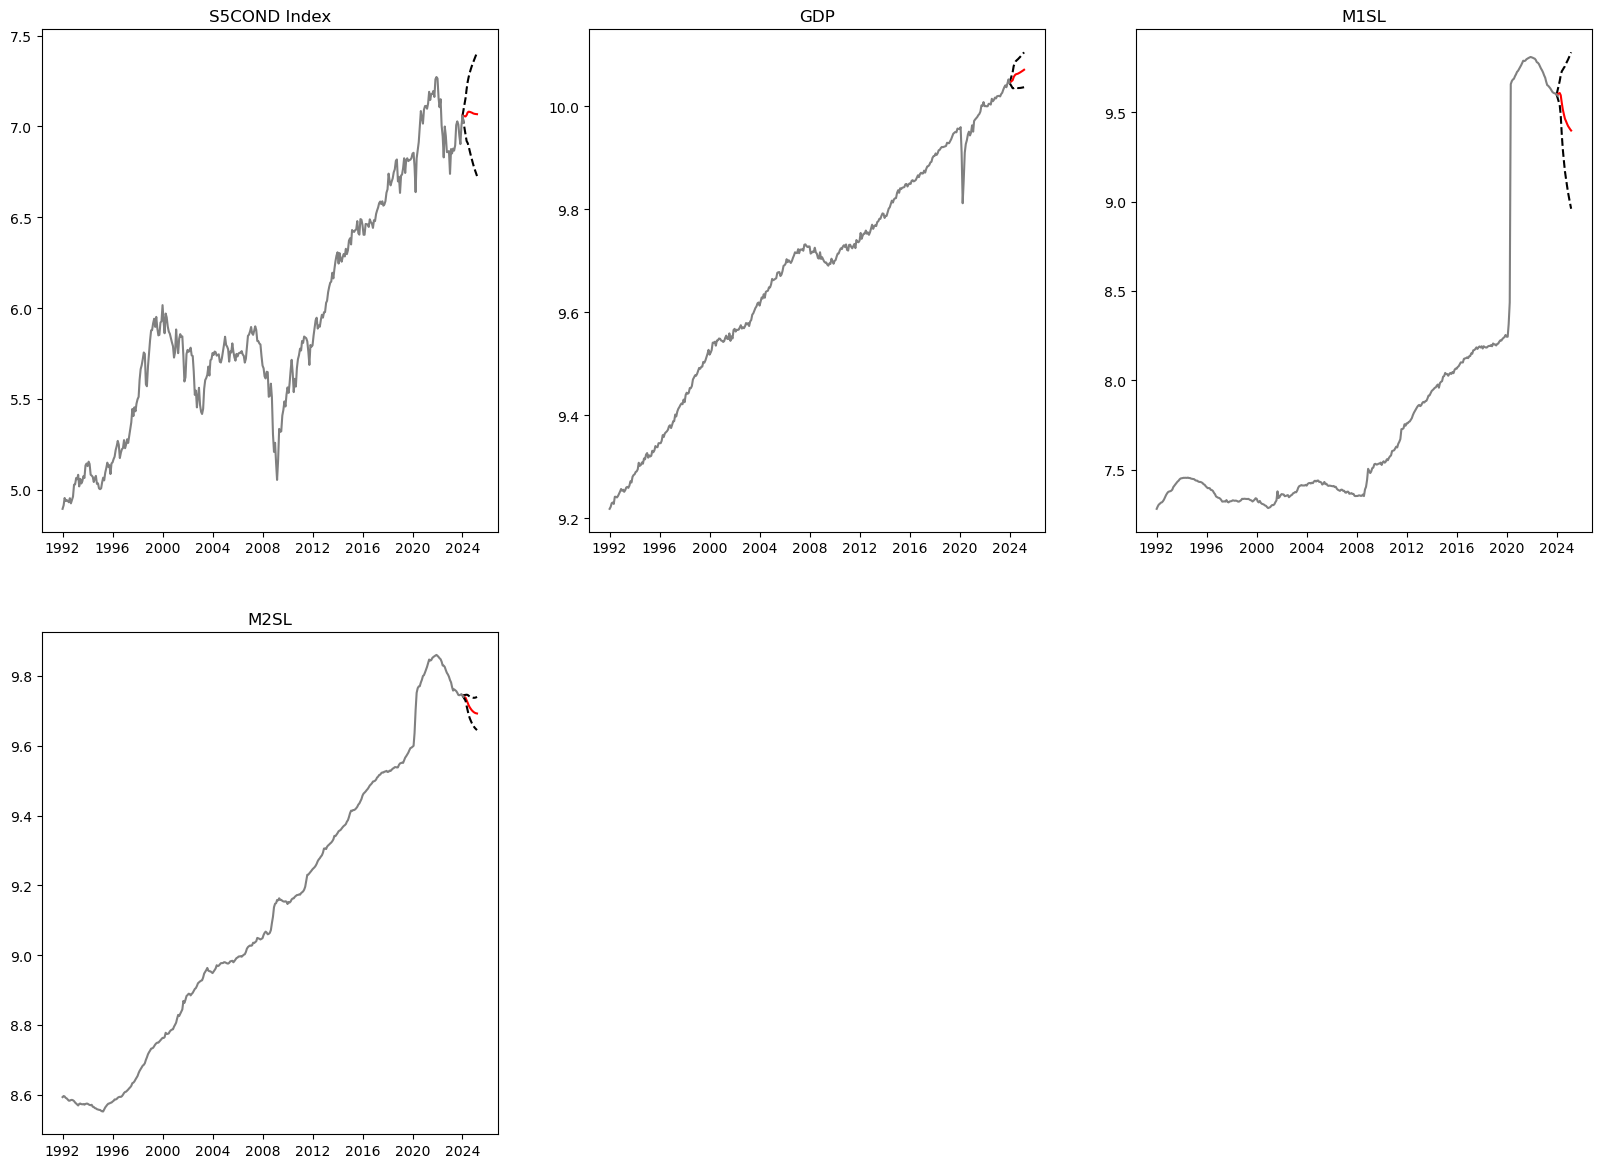

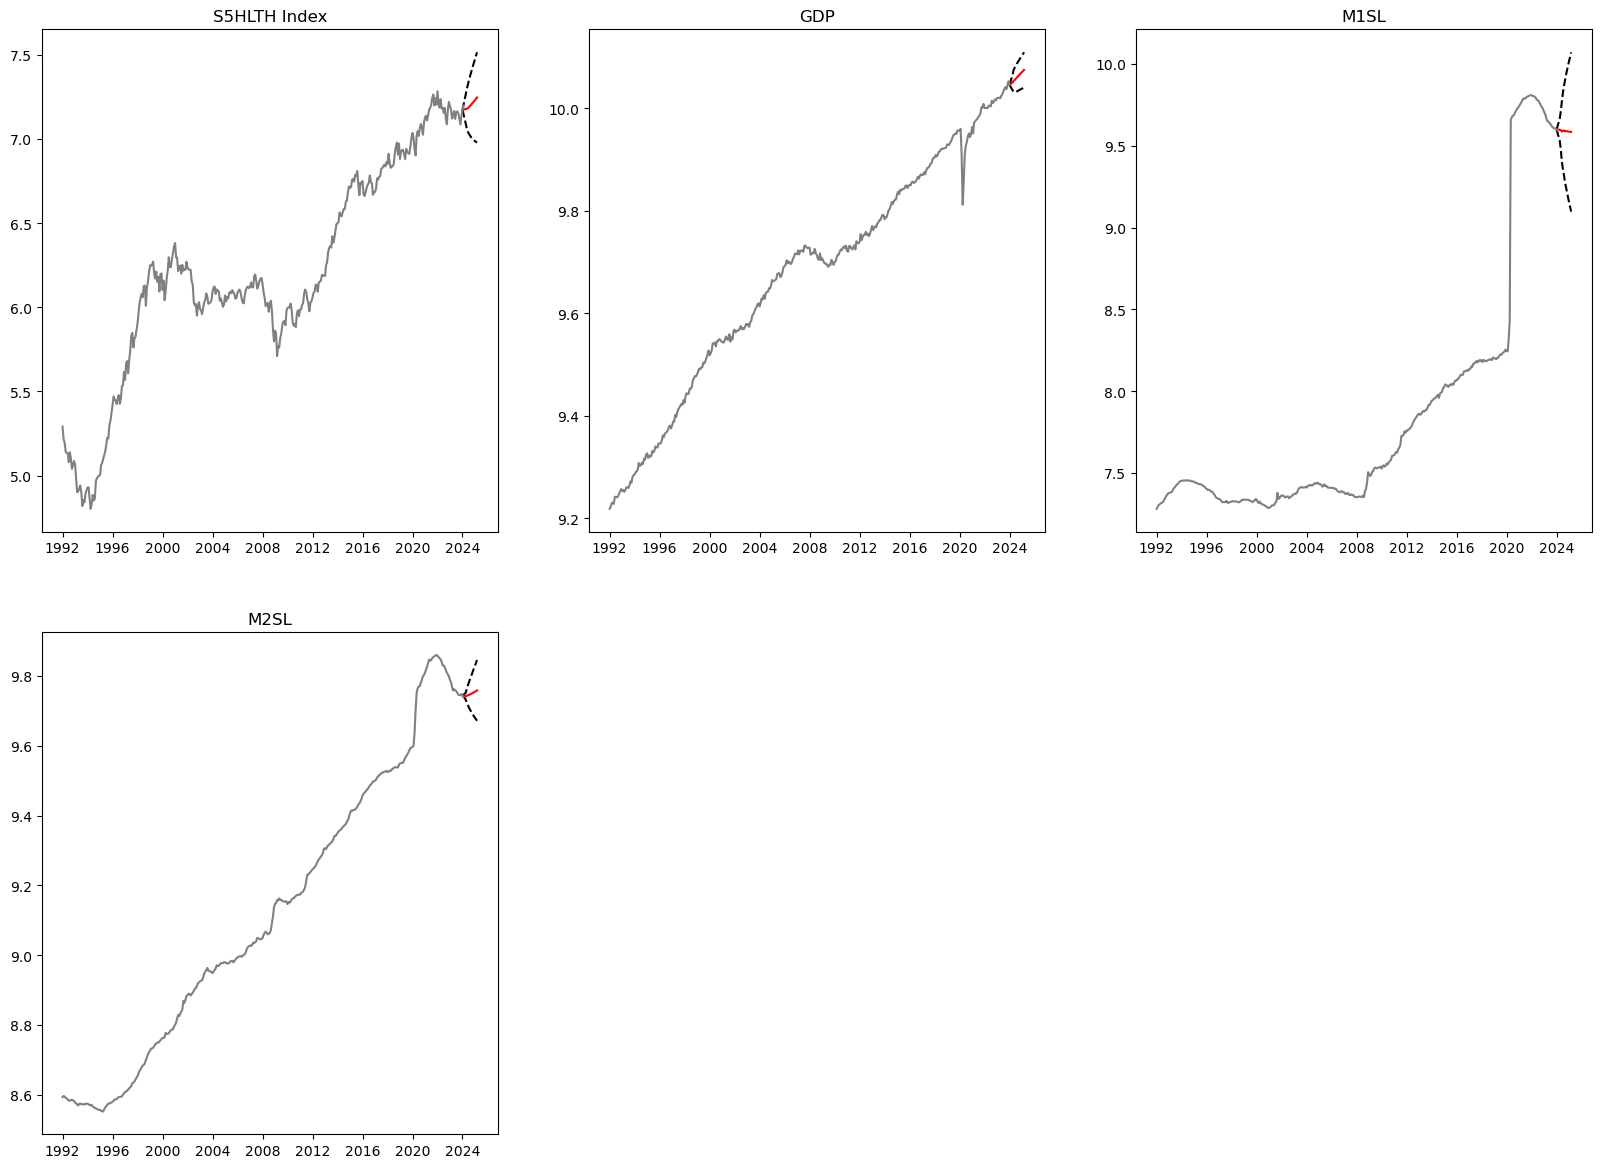

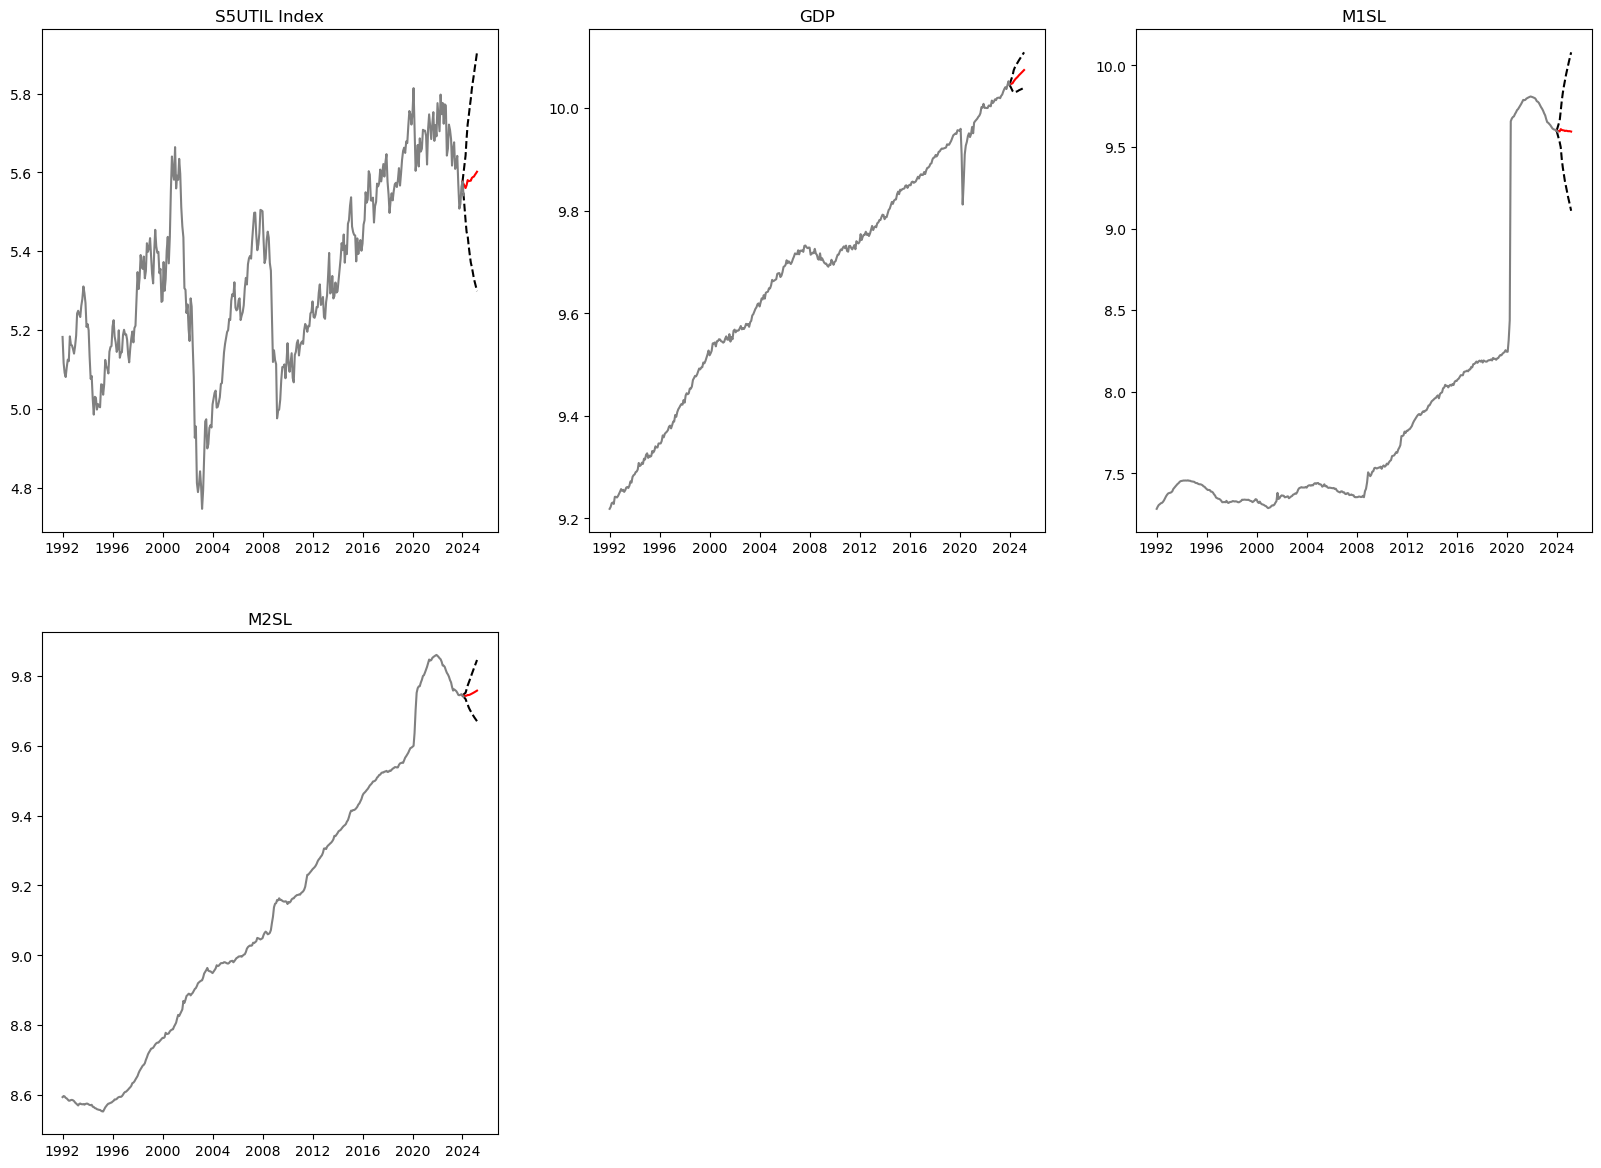

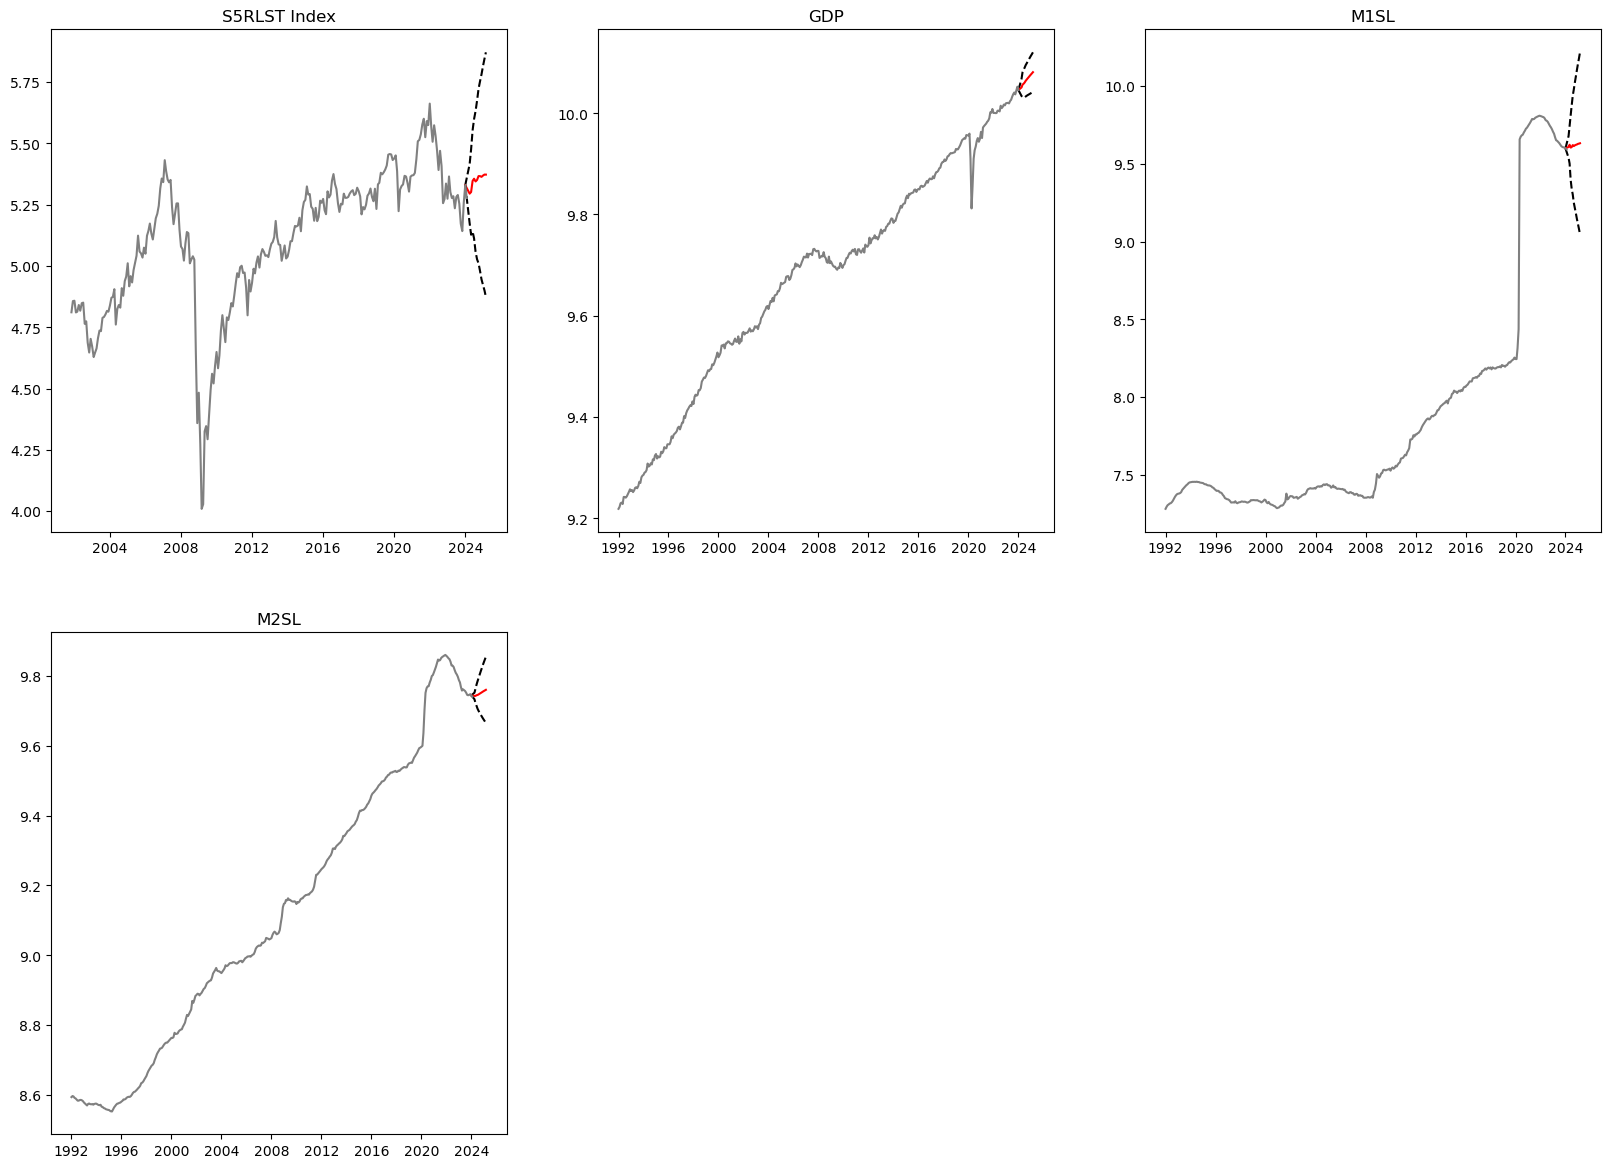

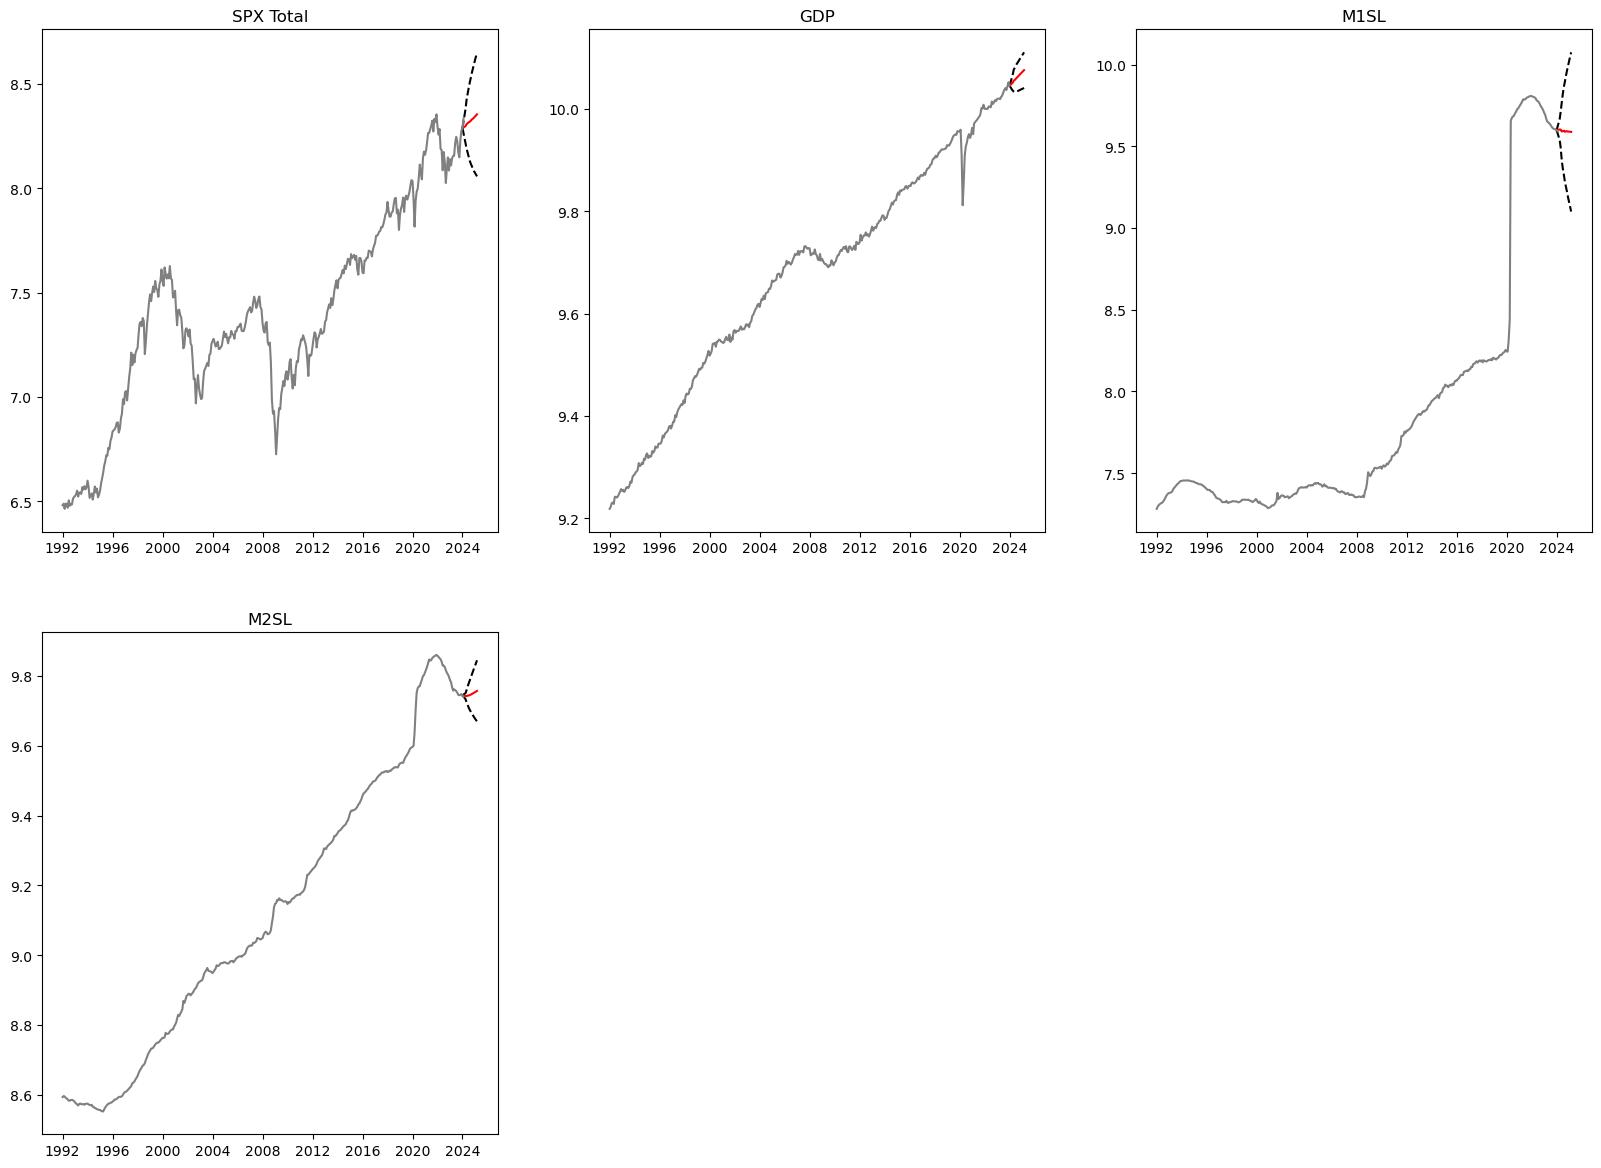

In [26]:
for industry in industry_names:
    industry_df = industry_dataframes[industry]['industry_df']
    exogenous_df = industry_dataframes[industry]['exogenous_df']
        
    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[0], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    
    # Forecast using the VECM model
    forecast, lower, upper = vecm_res.predict(steps=12, exog_fc=exogforecast, alpha=0.05)
    forecast_df = pd.DataFrame(forecast, columns=industry_df.columns, index=exogforecast.index)
    lower_ci = pd.DataFrame(lower, columns=industry_df.columns, index=exogforecast.index)
    upper_ci = pd.DataFrame(upper, columns=industry_df.columns, index=exogforecast.index)

    # Fix for last observation: use .iloc[-1] for single value
    last_obs = industry_df.iloc[-1]  # Get the last row as a Series
    
    forecast_df = pd.concat([last_obs.to_frame().T, forecast_df], ignore_index=False)
    lower_ci = pd.concat([last_obs.to_frame().T, lower_ci], ignore_index=False)
    upper_ci = pd.concat([last_obs.to_frame().T, upper_ci], ignore_index=False)

    plt.figure(figsize=(20, 30)) 
    for i, col in enumerate(forecast_df.columns):
        ax = plt.subplot(4, 3, i+1)
        ax.plot(upper_ci.index, upper_ci[col], color='black', linestyle='--')
        ax.plot(forecast_df.index, forecast_df[col], color='red')
        ax.plot(lower_ci.index, lower_ci[col], color='black', linestyle='--')
        ax.plot(treated_vars.index, treated_vars[col], color='gray')
        ax.set_title(col)


    

In [27]:
for industry in industry_names:
    industry_df = industry_dataframes[industry]['industry_df']
    exogenous_df = industry_dataframes[industry]['exogenous_df']
    print(industry_df)
    

            S5TELS Index        GDP      M1SL      M2SL
Date                                                   
1992-01-01      4.953396   9.218596  7.281682  8.593784
1992-02-01      4.900830   9.222497  7.295273  8.596794
1992-03-01      4.868955   9.229563  7.305208  8.595522
1992-04-01      4.866014   9.230938  7.310063  8.591591
1992-05-01      4.941708   9.228141  7.315912  8.589937
...                  ...        ...       ...       ...
2023-09-01      5.244037  10.040854  9.613623  9.745552
2023-10-01      5.210452  10.037192  9.608921  9.744655
2023-11-01      5.190330  10.045067  9.605880  9.746028
2023-12-01      5.264290  10.052380  9.605033  9.747724
2024-01-01      5.307251  10.045705  9.599324  9.744157

[385 rows x 4 columns]
            S5ENRS Index        GDP      M1SL      M2SL
Date                                                   
1992-01-01      4.995007   9.218596  7.281682  8.593784
1992-02-01      4.940552   9.222497  7.295273  8.596794
1992-03-01      4.919051

In [28]:
for industry in industry_names:
    industry_df = industry_dataframes[industry]['industry_df']
    exogenous_df = industry_dataframes[industry]['exogenous_df']
    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[0], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    ir = vecm_res.irf(periods=30)
    ir.plot(plot_stderr=False)

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ValueError: shapes (0,4) and (5,380) not aligned: 4 (dim 1) != 5 (dim 0)

In [ ]:
treated_vars

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total,GDP,M1SL,M2SL,10Y Treasury,FEDFUNDS
Date,,,,,,,,,,,,,,,,,
1992-01-01,4.953396,4.995007,4.706243,4.909154,4.883985,4.870485,5.042097,4.895529,5.291300,5.182271,NaN,6.481024,9.218596,7.281682,8.593784,7.03,4.03
1992-02-01,4.900830,4.940552,4.759551,4.913662,4.863532,4.884224,5.008026,4.914698,5.215226,5.116171,NaN,6.487984,9.222497,7.295273,8.596794,7.34,4.06
1992-03-01,4.868955,4.919051,4.801181,4.935055,4.895446,4.906437,5.004117,4.955299,5.196936,5.091146,NaN,6.463517,9.229563,7.305208,8.595522,7.54,3.98
1992-04-01,4.866014,4.883197,4.747315,4.904093,4.873553,4.908080,4.988977,4.938447,5.141631,5.080503,NaN,6.488186,9.230938,7.310063,8.591591,7.48,3.73
1992-05-01,4.941708,4.978866,4.758143,4.924612,4.882707,4.963616,4.995603,4.943475,5.135006,5.104459,NaN,6.488060,9.228141,7.315912,8.589937,7.39,3.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,5.190330,6.286996,7.780622,6.530901,6.094181,5.977885,6.382556,6.902853,7.087055,5.520240,5.142309,8.233723,10.045067,9.605880,9.746028,4.50,5.33
2023-12-01,5.264290,6.269150,7.899171,6.611318,6.194397,6.054114,6.418074,7.003798,7.136810,5.563228,5.256808,8.275744,10.052380,9.605033,9.747724,4.02,5.33
2024-01-01,5.307251,6.263466,7.932615,6.673768,6.241829,6.092785,6.438286,7.058983,7.173636,5.576223,5.329681,8.287746,10.045705,9.599324,9.744157,4.06,5.33
